# 14MBID - TFM

# El parque automovilístico de segunda mano en España. Análisis y estimación del precio de venta

## Manuel Campoy Naranjo

### Cuaderno 4

En este cuaderno se hace el análisis descriptivo, prueba y ajuste de modelos para el dataframe df_2mano_pop

## Importación de paquetes y librerías. Configuración de rutas y figuras

In [ ]:
!pip install jcopml --quiet
!pip install feature_selector --no-binary=:all: --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Running setup.py install for feature_selector ... done


In [ ]:
import time
import os
import io
import pandas as pd
import numpy as np
from numpy import corrcoef, transpose, arange
import seaborn as sns
import plotly.express as px
from google.colab import drive
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from matplotlib.animation import FuncAnimation

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

#ML

from sklearn import ensemble, preprocessing, metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from feature_selector import FeatureSelector 
from jcopml.tuning import random_search_params as rsp
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_correlation_matrix
from jcopml.plot import plot_actual_vs_prediction, plot_residual
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE,chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.linear_model import Lasso, SGDClassifier, LassoCV, MultiTaskLassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.utils import resample,shuffle

In [ ]:
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/TFM/Datasets"

 accidentes.xlsx		    'ventas marca 2019.xlsx'
 autocasion2mano.xlsx		    'ventas marca 2020.xlsx'
 autocasionnuevos.xlsx		    'ventas marca 2021.xlsx'
 coches-de-segunda-mano-sample.csv  'ventas marca 2022.xlsx'
 cochesnetnuevos.xlsx		    'ventas modelo 2015.xlsx'
 datosBI.xlsx			    'ventas modelo 2016.xlsx'
 df_2mano_dummies.xlsx		    'ventas modelo 2017.xlsx'
 df_2mano_pop_dummies.xlsx	    'ventas modelo 2018.xlsx'
 df_2mano_pop_pre_dummies.xlsx	    'ventas modelo 2019.xlsx'
 df_2mano_pop_pre.xlsx		    'ventas modelo 2020.xlsx'
 df_2mano_pop.xlsx		    'ventas modelo 2021.xlsx'
 df_2mano.xlsx			    'ventas modelo 2022.xlsx'
 df_provincias.xlsx		    'ventas provincia 2015.xlsx'
 parque.xlsx			    'ventas provincia 2016.xlsx'
 pib-capita.xlsx		    'ventas provincia 2017.xlsx'
 poblacion.xlsx			    'ventas provincia 2018.xlsx'
 transferencias.xlsx		    'ventas provincia 2019.xlsx'
'ventas marca 2015.xlsx'	    'ventas provincia 2020.xlsx'
'ventas marca 2016.xlsx'	    'ventas provincia 2

Se crea un path de acceso para más comodidad (tanto en local como en Drive)

In [ ]:
#path = '/Users/mcamp/OneDrive/Escritorio/TFM/'
#path = '/Users/manolo/Documents/Personales/Estudios/Máster Big Data y Data Science/Asignaturas/14MBID - TFM/Datasets/'
path = '/content/drive/My Drive/TFM/Datasets/'

## Importación del dataframe


In [ ]:
df_2mano_pop = pd.read_excel(path+'df_2mano_pop.xlsx', index_col=[0])

In [ ]:
df_2mano_pop.dtypes

Marca           object
Modelo          object
Precio           int64
Combustible     object
Año              int64
Kilometraje      int64
Potencia       float64
Cambio          object
Fotos            int64
Provincia       object
Pop. Marca     float64
Pop. Modelo    float64
dtype: object

## Estadística descriptiva

### Variables numéricas

Realizamos un análisis descriptivo que nos permita ver si es necesario hacer algunas modificaciones adicionales en el dataframe a las ya realizadas durante el preprocesado y limpieza

In [ ]:
df_2mano_pop.describe()

,Precio,Año,Kilometraje,Potencia,Fotos,Pop. Marca,Pop. Modelo
count,4.360900e+04,43609.000000,4.360900e+04,43609.000000,43609.000000,43609.000000,43609.000000
mean,3.042565e+04,2018.313169,5.196391e+04,160.342842,21.570456,3.480348,5.049916
std,4.654091e+04,2.018671,6.819723e+04,96.337358,12.356542,4.773550,12.899812
min,1.000000e+02,2015.000000,0.000000e+00,2.000000,0.000000,0.000000,0.000000
25%,1.545000e+04,2017.000000,1.034000e+04,110.000000,12.000000,1.376741,1.034238
50%,2.140000e+04,2018.000000,3.771300e+04,136.000000,20.000000,3.301211,3.396711
75%,3.090000e+04,2020.000000,8.128300e+04,170.000000,29.000000,5.043193,6.460149
max,1.500000e+06,2022.000000,8.067058e+06,1332.000000,165.000000,138.906913,521.985742


Se observa que el precio medio de venta es de unos 30000 euros. El año promedio es de sobre 2018.

(array([0]), <a list of 1 Text major ticklabel objects>)

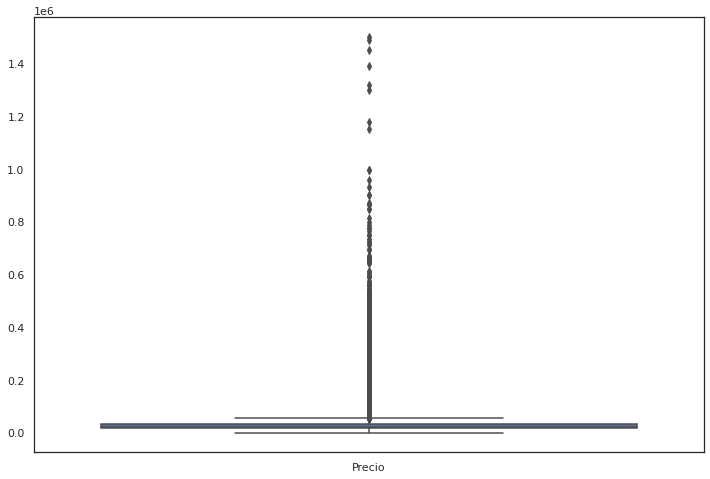

In [ ]:
sns.set(style="white")
sns.boxplot(data=df_2mano_pop[['Precio']])
plt.xticks(rotation=0)

Hay coches con un valor muy bajo (unos 100 euros) y otros excesivamente altos (el máximo está en más de 760000).

Vamos a ver los coches que tiene una valor inferior a 300 euros

In [ ]:
df_2mano_pop.loc[df_2mano_pop['Precio'] <= 300]

,Marca,Modelo,Precio,Combustible,Año,Kilometraje,Potencia,Cambio,Fotos,Provincia,Pop. Marca,Pop. Modelo
12196,BMW,SERIE 3,100,Diesel,2019,10000,190.0,Automatico,13,Palencia,4.361974,3.209713


Vamos a eliminar los coches que tienen un precio inferior a 300 euros, puesto que parece que son una errata

In [ ]:
df_2mano_pop = df_2mano_pop.loc[(df_2mano_pop['Precio'] >= 300)]

Vemos los coches que tienen un precio excesivamente alto

In [ ]:
df_2mano_pop.loc[df_2mano_pop['Precio'] >= 200000]

,Marca,Modelo,Precio,Combustible,Año,Kilometraje,Potencia,Cambio,Fotos,Provincia,Pop. Marca,Pop. Modelo
7583,MERCEDES-BENZ,CLASE G,358900,Gasolina,2019,4300,585.0,Automatico,19,Barcelona,1.587562,0.080037
7584,MERCEDES-BENZ,CLASE G,237000,Gasolina,2019,77000,585.0,Automatico,36,Salamanca,1.587562,0.080037
7587,MERCEDES-BENZ,CLASE G,229990,Gasolina,2019,40000,585.0,Automatico,30,Pontevedra,1.587562,0.080037
7594,MERCEDES-BENZ,CLASE S,727900,Gasolina,2019,90,630.0,Automatico,15,Madrid,1.587562,0.041438
7647,MERCEDES-BENZ,AMG,221900,Gasolina,2019,3699,585.0,Automatico,24,Madrid,1.587562,0.052790
...,...,...,...,...,...,...,...,...,...,...,...,...
43024,ROLLS-ROYCE,GHOST,279900,Gasolina,2019,29000,570.0,Automatico,23,Madrid,0.000271,0.000568
43041,MCLAREN,720S,249999,Gasolina,2019,28000,815.0,Automatico,81,Madrid,0.001990,0.002271
43042,MCLAREN,720S,306900,Gasolina,2019,5980,815.0,Automatico,28,Madrid,0.001990,0.002271
43321,BMW,SERIE 3,1149990,Gasolina,2022,1,510.0,Automatico,30,Pontevedra,0.893637,0.291199


Vemos un histograma con la distribución de precios

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


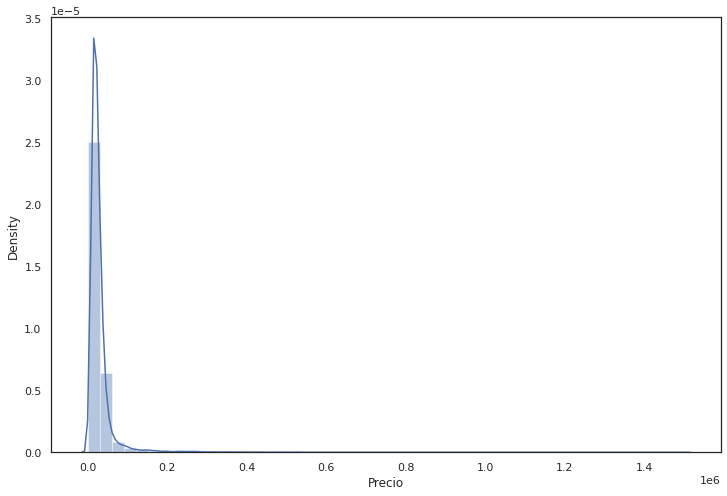

In [ ]:
sns.distplot(df_2mano_pop['Precio'])

Vemos que son coches de marcas premium y que apenas hay instancias con precios superiores a 200000 euros (sólo 483 instancias)

No son muchos instancias, pero seguramente van a hacer que nuestro modelo no sea excesivamente bueno prediciendo en el rango alto de valores.

Podríamos tomar la decisión de eliminar esas instancias, pero entonces nuestro modelo no recogería estas "anomalías". Tomamos la decisión de mantenerlas (al menos por el momento)

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df_2mano_pop['Precio'].skew())
print("Kurtosis: %f" % df_2mano_pop['Precio'].kurt())

Skewness: 11.352986
Kurtosis: 208.762495


Los valores muestran que la distribución es bastante asimétrica (con asimetría positiva) y con gran concentración de valores respecto a la media

(array([0]), <a list of 1 Text major ticklabel objects>)

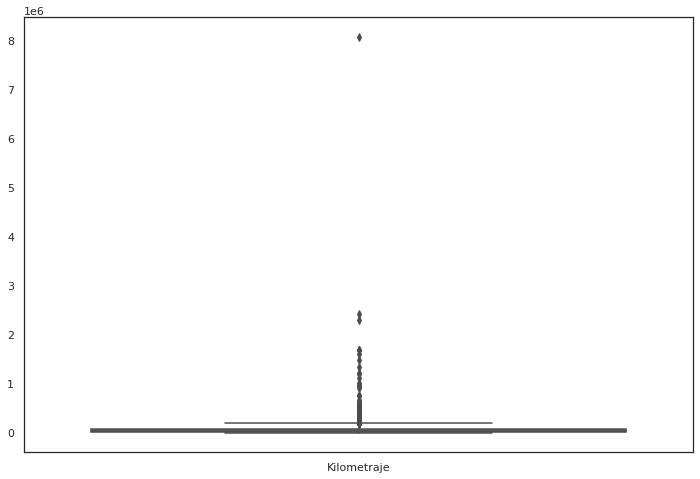

In [ ]:
sns.set(style="white")
sns.boxplot(data=df_2mano_pop[['Kilometraje']])
plt.xticks(rotation=0)

Hay coches que tienen un kilometraje excesivo. Vemos cuáles son

In [ ]:
df_2mano_pop.loc[df_2mano_pop['Kilometraje'] >= 500000]

,Marca,Modelo,Precio,Combustible,Año,Kilometraje,Potencia,Cambio,Fotos,Provincia,Pop. Marca,Pop. Modelo
1001,PEUGEOT,308,8000,Diesel,2016,1210000,180.0,Automatico,2,Madrid,6.810072,12.839682
7114,SEAT,IBIZA,10490,Gasolina,2016,628333,95.0,Manual,17,Cantabria,3.809262,13.325890
11061,BMW,SERIE 3,16000,Diesel,2016,940000,116.0,Manual,1,Barcelona,5.421413,6.406959
11089,BMW,SERIE 3,7850,Diesel,2016,960028,150.0,Automatico,7,Castellón,5.421413,6.406959
16251,PEUGEOT,3008,15850,Diesel,2018,774147,150.0,Manual,9,Ciudad Real,6.015228,10.735334
18421,VOLKSWAGEN,GOLF,50000,Diesel,2017,2300000,149.0,Automatico,0,Madrid,5.977353,11.814103
19078,TOYOTA,LAND CRUISER,28500,Diesel,2016,1600991,177.0,Manual,47,Sevilla,1.525327,1.325606
19846,BMW,SERIE 1,8350,Diesel,2015,1121342,116.0,Automatico,6,Pontevedra,4.372966,5.538458
19862,BMW,I3,8750,Electrico,2015,1330000,170.0,Automatico,4,Málaga,1.234012,6.522961
22081,FORD,S-MAX,8900,Diesel,2015,564000,150.0,Manual,14,Málaga,4.084269,1.552497


Hay coches con más de un millón de kms. Podría ser cierto, pero parece complicado de creer (teniendo en centa la antigüedad de los mismos). Vamos a eliminar aquellos por encima del millón de kms.

In [ ]:
df_2mano_pop = df_2mano_pop.loc[(df_2mano_pop['Kilometraje'] <= 1e6)]

Vemos la distribución de Año de matriculación

(array([0]), <a list of 1 Text major ticklabel objects>)

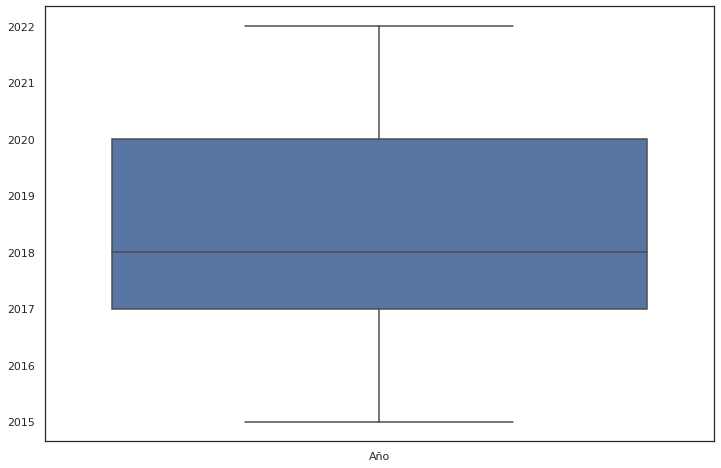

In [ ]:
sns.set(style="white")
sns.boxplot(data=df_2mano_pop[['Año']])
plt.xticks(rotation=0)

Vemos ahora la distribución de potencia y del número de fotos del anuncio

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

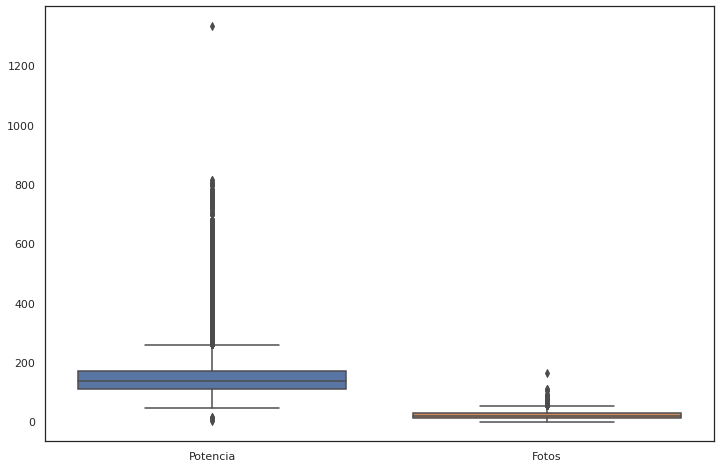

In [ ]:
sns.set(style="white")
sns.boxplot(data=df_2mano_pop[['Potencia', 'Fotos']])
plt.xticks(rotation=0)

Hay algunos vehículos con potencias muy altas y otros con potencia demasiado bajas. Vamos a verlo

In [ ]:
df_2mano_pop.loc[df_2mano_pop['Potencia'] <= 40]

,Marca,Modelo,Precio,Combustible,Año,Kilometraje,Potencia,Cambio,Fotos,Provincia,Pop. Marca,Pop. Modelo
1480,CITROEN,C1,8100,Gasolina,2018,60000,8.0,Manual,0,Huelva,3.974694,1.261294
22361,CITROEN,C1,7700,Electrico,2021,173,8.0,Automatico,15,Zamora,2.571548,0.000000
41173,AUDI,Q8,74200,Diesel,2022,10,16.0,Automatico,5,Ciudad Real,2.531529,0.324961
41213,AUDI,A6,50700,Diesel,2022,10,2.0,Automatico,9,Ciudad Real,2.531529,0.465417
41221,AUDI,Q7,64400,Diesel,2022,10,16.0,Automatico,4,Ciudad Real,2.531529,0.295041


In [ ]:
df_2mano_pop.loc[df_2mano_pop['Potencia'] >= 800]

,Marca,Modelo,Precio,Combustible,Año,Kilometraje,Potencia,Cambio,Fotos,Provincia,Pop. Marca,Pop. Modelo
7242,MERCEDES-BENZ,CLASE A,30500,Gasolina,2019,56000,1332.0,Manual,0,Valencia,1.587562,2.949452
38990,FERRARI,812,305400,Gasolina,2019,24000,800.0,Automatico,13,Valencia,0.006603,0.007947
40574,FERRARI,812,355000,Gasolina,2020,1800,800.0,Automatico,8,Málaga,0.004432,0.005109
43041,MCLAREN,720S,249999,Gasolina,2019,28000,815.0,Automatico,81,Madrid,0.001990,0.002271
43042,MCLAREN,720S,306900,Gasolina,2019,5980,815.0,Automatico,28,Madrid,0.001990,0.002271


Se observa que hay errores en los valores de potencia inferiores a 40 CV y también con el que pone que tiene más de 1000 CV. Los eliminamos

In [ ]:
df_2mano_pop = df_2mano_pop.loc[(df_2mano_pop['Potencia'] >= 40)]
df_2mano_pop = df_2mano_pop.loc[(df_2mano_pop['Potencia'] <= 900)]

Respecto de las fotografías, es razonable que haya una gran variabilidad, aunque aquellos casos en los que se disponen de más de 100 fotos parecen excesivos. En cualquier caso, esta característica está por ver si aporta algo o no.

In [ ]:
df_2mano_pop.reset_index(inplace = True, drop = True)

In [ ]:
df_2mano_pop.describe()

,Precio,Año,Kilometraje,Potencia,Fotos,Pop. Marca,Pop. Modelo
count,4.358900e+04,43589.000000,43589.000000,43589.000000,43589.000000,43589.000000,43589.000000
mean,3.042807e+04,2018.313198,51370.015600,160.338044,21.573860,3.480540,5.050393
std,4.654955e+04,2.018510,50019.430023,96.178792,12.355643,4.774456,12.902466
min,1.000000e+03,2015.000000,0.000000,44.000000,0.000000,0.000000,0.000000
25%,1.545000e+04,2017.000000,10340.000000,110.000000,12.000000,1.376741,1.034238
50%,2.140000e+04,2018.000000,37707.000000,136.000000,20.000000,3.301211,3.396711
75%,3.090000e+04,2020.000000,81237.000000,170.000000,29.000000,5.043193,6.460149
max,1.500000e+06,2022.000000,960028.000000,815.000000,165.000000,138.906913,521.985742


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

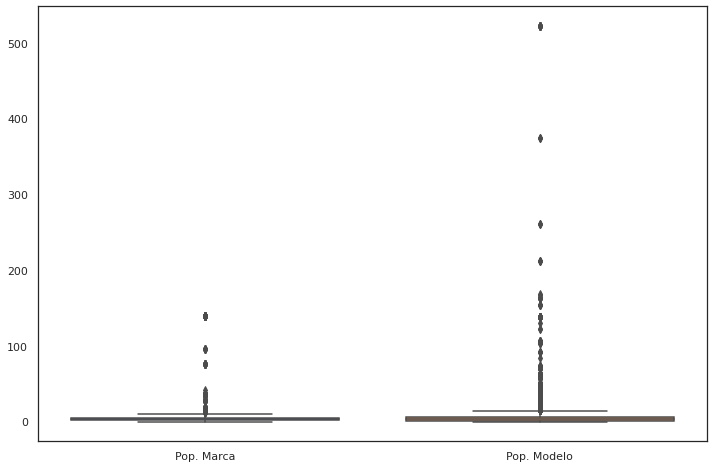

In [ ]:
sns.set(style="white")
sns.boxplot(data=df_2mano_pop[['Pop. Marca', 'Pop. Modelo']])
plt.xticks(rotation=0)

Hay algunos módelos y marcas con una popularidad altísima. Vemos cuáles son

In [ ]:
df_2mano_pop.loc[df_2mano_pop['Pop. Marca'] >= 15]

,Marca,Modelo,Precio,Combustible,Año,Kilometraje,Potencia,Cambio,Fotos,Provincia,Pop. Marca,Pop. Modelo
3941,SEAT,LEON,12000,GNC,2017,114000,110.0,Manual,7,Jaén,29.137951,167.964831
6747,OPEL,CORSA,12300,GLP,2019,15790,90.0,Manual,20,Málaga,36.845964,166.993245
7684,SEAT,LEON,18900,GNC,2020,540,130.0,Manual,15,Girona,75.883024,261.081554
7690,SEAT,LEON,18900,GNC,2020,12314,130.0,Manual,20,Girona,75.883024,261.081554
7691,SEAT,LEON,17900,GNC,2020,40,130.0,Manual,17,Madrid,75.883024,261.081554
...,...,...,...,...,...,...,...,...,...,...,...,...
42285,TESLA,MODEL Y,72900,Electrico,2022,3000,351.0,Automatico,1,Madrid,19.011234,48.415444
42286,TESLA,MODEL Y,76899,Electrico,2022,9842,480.0,Automatico,26,Málaga,19.011234,48.415444
42287,TESLA,MODEL 3,79800,Electrico,2022,100,441.0,Automatico,25,Pontevedra,19.011234,69.491625
42288,TESLA,MODEL 3,64950,Electrico,2022,100,441.0,Automatico,19,Madrid,19.011234,69.491625


In [ ]:
df_2mano_pop.loc[df_2mano_pop['Pop. Modelo'] >= 25]

,Marca,Modelo,Precio,Combustible,Año,Kilometraje,Potencia,Cambio,Fotos,Provincia,Pop. Marca,Pop. Modelo
1930,SKODA,OCTAVIA,17490,GNC,2019,18000,130.0,Automatico,33,Madrid,9.156834,57.466320
1932,SKODA,OCTAVIA,19400,GNC,2019,3092,130.0,Automatico,28,Palmas (Las),9.156834,57.466320
1933,SKODA,OCTAVIA,21500,GNC,2019,4500,130.0,Automatico,30,Madrid,9.156834,57.466320
1938,SKODA,OCTAVIA,19400,GNC,2019,1201,130.0,Automatico,28,Valencia,9.156834,57.466320
1939,SKODA,OCTAVIA,19800,GNC,2019,2770,130.0,Automatico,29,Palmas (Las),9.156834,57.466320
...,...,...,...,...,...,...,...,...,...,...,...,...
43074,FIAT,500,32400,Electrico,2022,3500,118.0,Automatico,17,Madrid,7.341956,46.076534
43075,FIAT,500,25700,Electrico,2022,4700,95.0,Automatico,18,Madrid,7.341956,46.076534
43077,FIAT,500,30500,Electrico,2022,1,57.0,Automatico,28,Madrid,7.341956,46.076534
43158,MINI,MINI,46900,Electrico,2022,10,184.0,Automatico,15,Madrid,5.201070,32.640793


Los outliers de las popularidades corresponden con marcas/modelos un poco especiales. Como se ha obtenido por tipo de combustible, en aquellos combustibles menos habituales (eléctrico, GNC y GLP), los valores de popularidad son más extremos (o muy bajos, o muy altos). Si esto afectara mucho al modelo a la hora de predecir, podría ser necesario plantear una definición diferente de popularidad.

Podemos ver también la correlación que hay entre las variables numéricas (excluyendo la variable objetivo, que es la que precisamente queremos correlacionar).

Para esto, nos quedamos sólo con las variables numéricas y quitamos la columna 'Precio'

In [ ]:
df_2mano_pop_num = df_2mano_pop.select_dtypes(include=[np.number])
df_2mano_pop_num = transpose(df_2mano_pop_num.drop(['Precio'], axis = 1))
nombres_num = df_2mano_pop_num.index

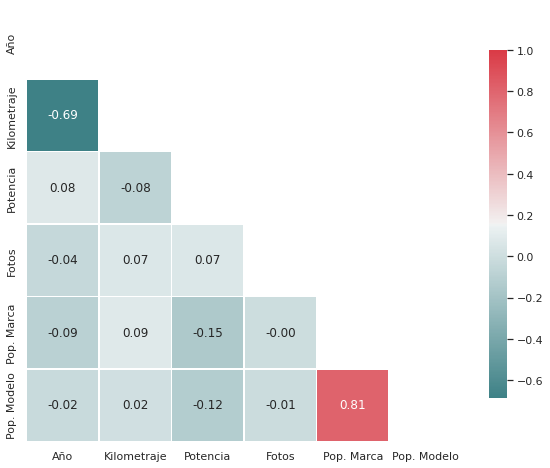

In [ ]:
R = corrcoef(df_2mano_pop_num)
sns.set(style="white")
mask = np.zeros_like(R, dtype = bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 8))

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(R, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=nombres_num, yticklabels=nombres_num, annot=True, fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)

Se puede observar que hay una correlación bastante alta entre la popularidad de la marca y la del modelo.
Se observa que hay una correlación moderada entre los kilometros y el año (algo que tiene sentido, ya que mientras más nuevo sea el coche, menos kilómetros suele haber recorrido). Decidimos no quitar ninguna de las variables

Si se analiza la correlación incluyendo el precio de venta (variable objetivo)

In [ ]:
df_2mano_pop_num = df_2mano_pop.select_dtypes(include=[np.number])
df_2mano_pop_num = transpose(df_2mano_pop_num)
nombres_num = df_2mano_pop_num.index

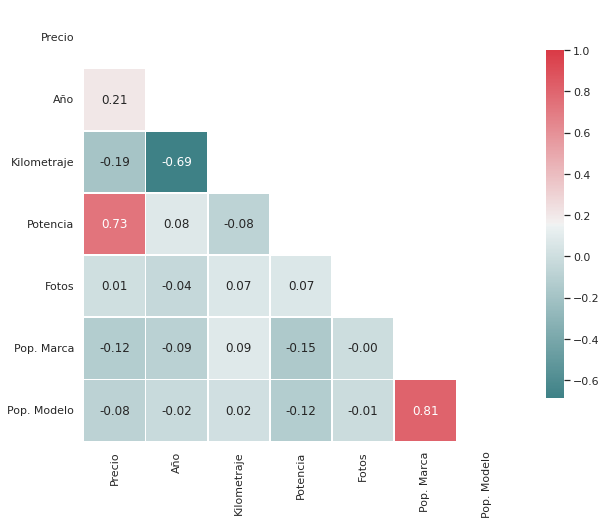

In [ ]:
R = corrcoef(df_2mano_pop_num)
sns.set(style="white")
mask = np.zeros_like(R, dtype = bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 8))

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(R, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=nombres_num, yticklabels=nombres_num, annot=True, fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)

Se observa una correlación moderada entre el precio del vehículo y la potencia (algo que es podría ser lógico)

### Variables categóricas

En el dataframe existen variables que son de tipo categórico, como son la marca, el modelo, o la provincia.

Verificamos en primer lugar el número de categorías que tenemos en cada una de las variables de este tipo

In [ ]:
df_2mano_pop_cat = df_2mano_pop.select_dtypes(exclude=[np.number])
cat_cols = df_2mano_pop_cat.columns.values
df_2mano_pop_cat.nunique(axis=0)

Marca           52
Modelo         352
Combustible      5
Cambio           2
Provincia       52
dtype: int64

Vemos que hay muchas categorías en algunas de las variables, como es el caso de Modelo (352 categorías)

Vamos a ver la distribución de categorías en la variable Marca, ya que tiene un número más o menos manejable

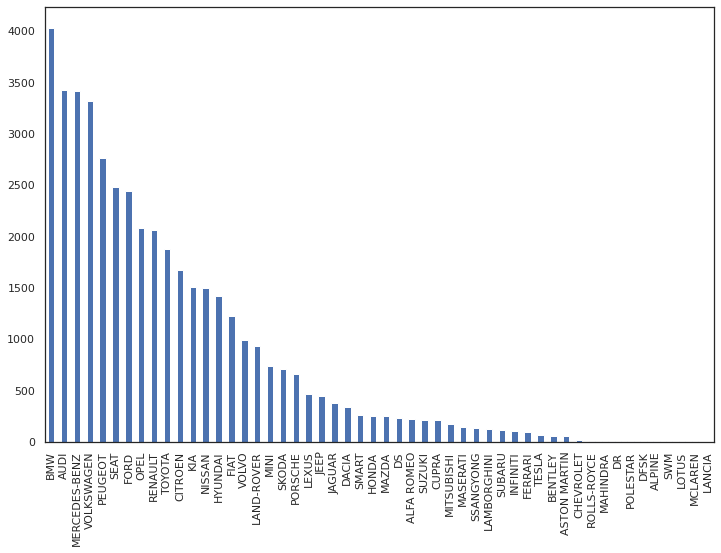

In [ ]:
sns.set(style="white")
df_2mano_pop['Marca'].value_counts().plot.bar()

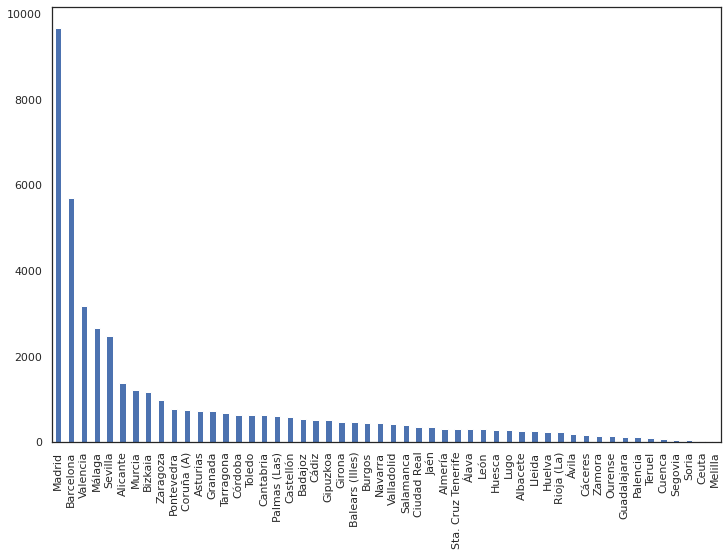

In [ ]:
sns.set(style="white")
df_2mano_pop['Provincia'].value_counts().plot.bar()

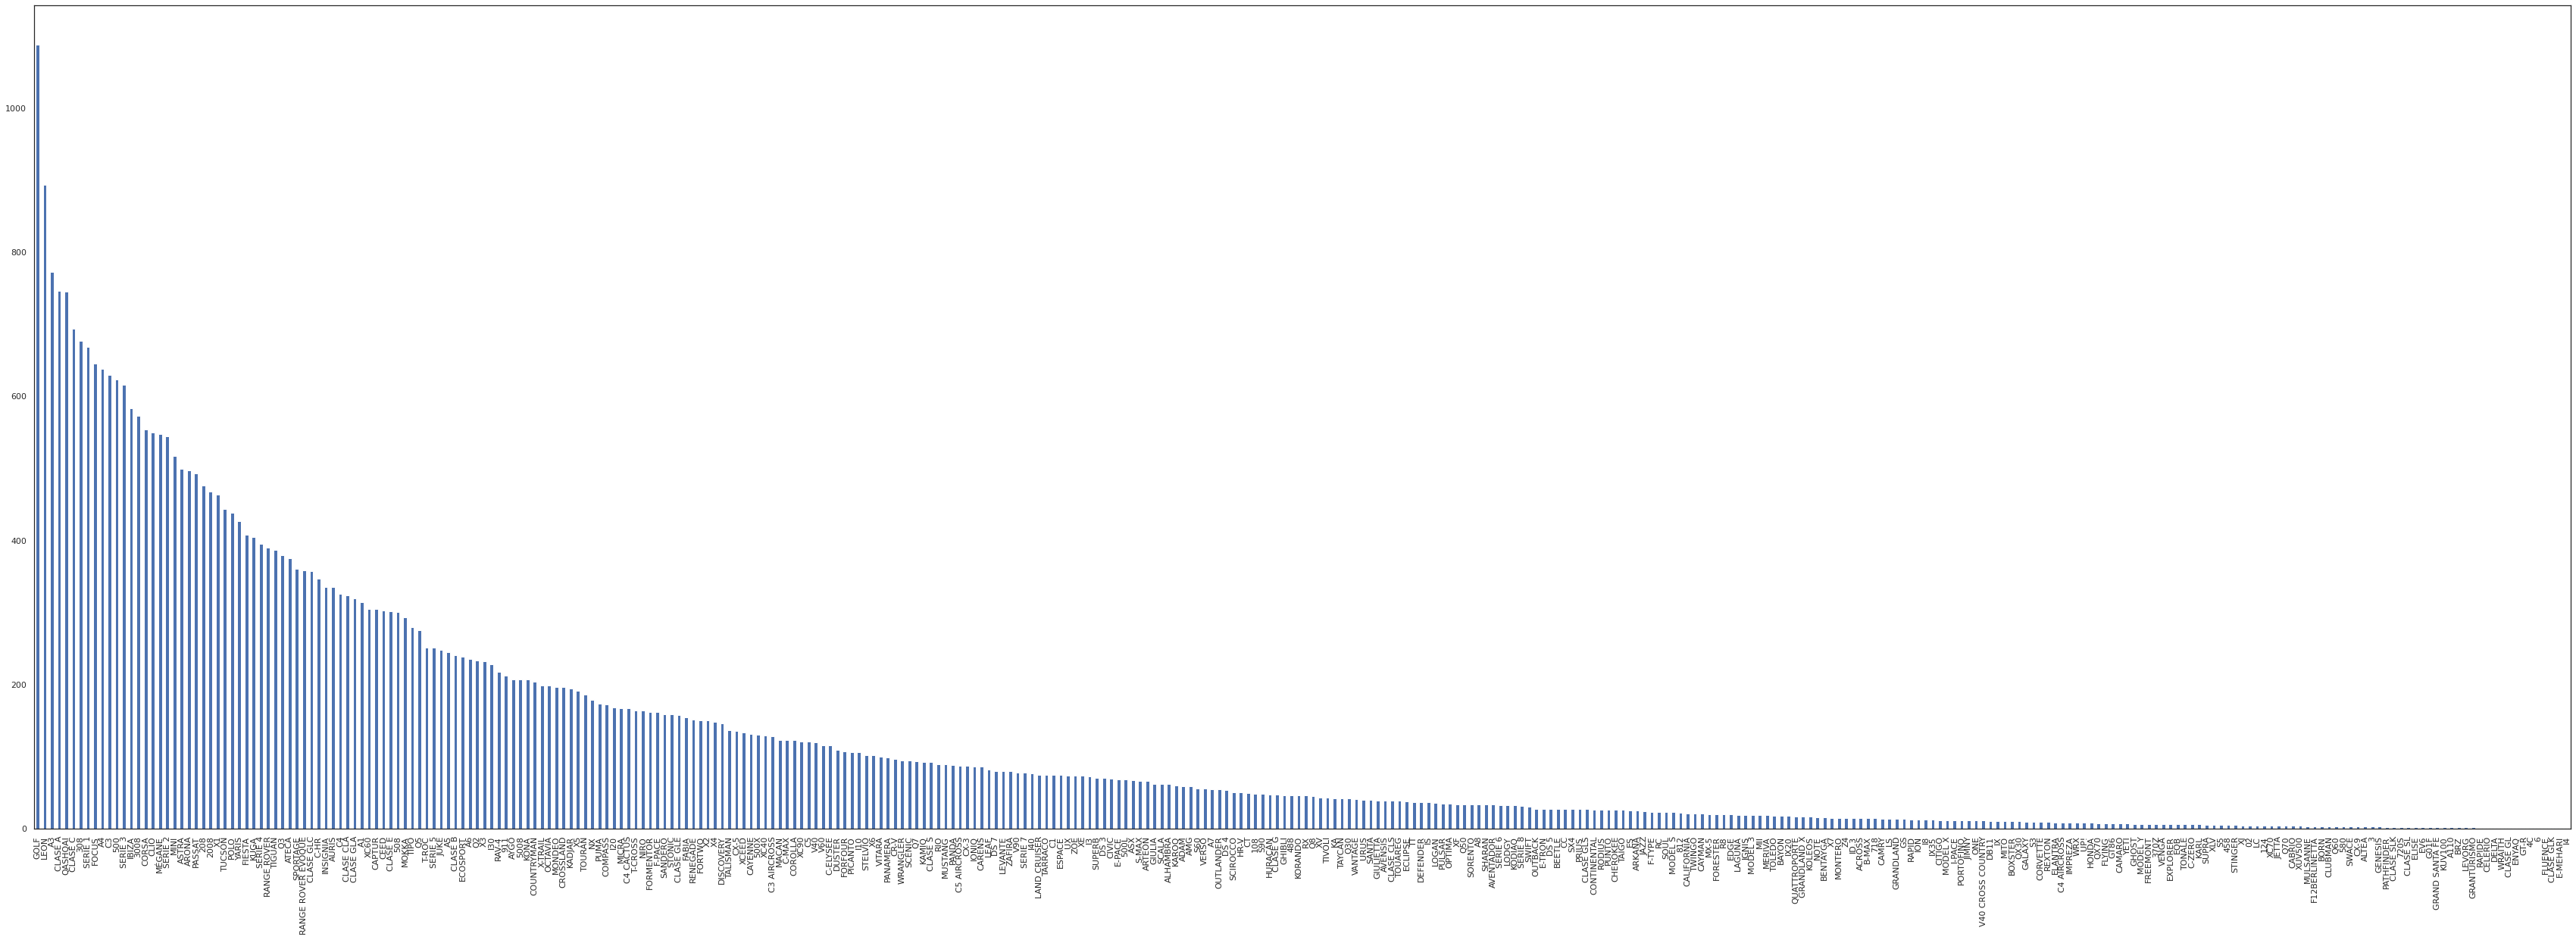

In [ ]:
sns.set(style="white")
fig, ax = plt.subplots(figsize=(60, 20))
df_2mano_pop['Modelo'].value_counts().plot.bar()

Podemos ver agrupado por marcas y modelos

In [ ]:
fig = px.treemap(data_frame= df_2mano_pop, path=["Marca","Modelo","Combustible"])
fig.show()

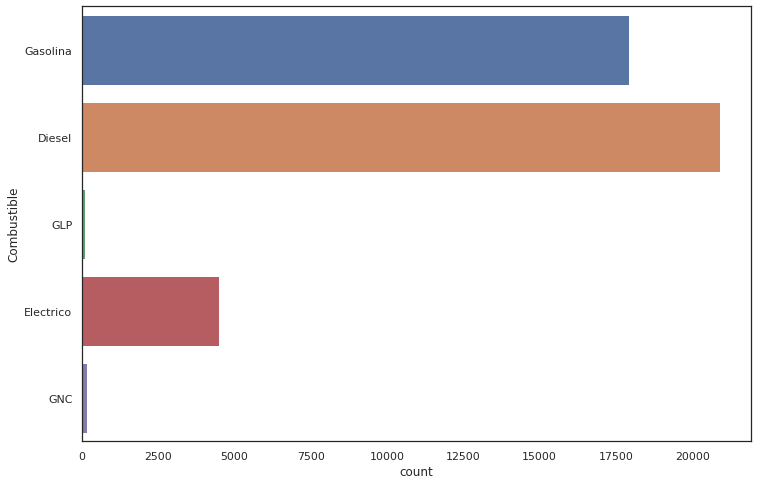

In [ ]:
sns.set(style="white")
sns.countplot(y="Combustible", data=(df_2mano_pop))

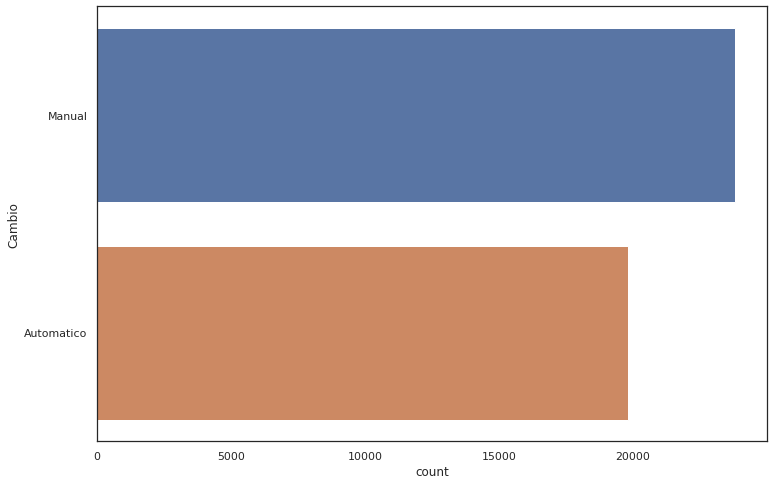

In [ ]:
sns.set(style="white")
sns.countplot(y="Cambio", data=(df_2mano_pop))

Vemos como queda el dataframe usando variables dummies (variables ficticias) para codificar las variables categóricas.

In [ ]:
df_2mano_pop_dummies = pd.get_dummies(df_2mano_pop, sparse = True)

In [ ]:
df_2mano_pop_dummies.shape

(43589, 470)

Al usar variables dummies, el número de características se vuelve muy grande. De ese modo, vamos a proceder a realizar el modelado en un principio con todas las características y, posteriormente, haciendo una reducción de características usando el FeatureSelectorpara ver si es posible hacer un ajuste razonable con menos variables

## Modelado para predicción del precio de vehículos usados

Hacemos el ajuste usando todas las variables del dataframe

### Preprocesado

Al tener variables numéricas y categóricas, hacemos un preprocesado en primer lugar

In [ ]:
num_feat = ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo']
cat_feat = ['Marca', 'Modelo', 'Combustible', 'Cambio', 'Provincia']

feat = num_feat + cat_feat

target = 'Precio'

Separamos dos conjuntos de datos, utilizando un 25% de los datos para test y el resto para entrenar

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df_2mano_pop.drop(columns = target),
                                        df_2mano_pop[target],
                                        test_size=0.25,
                                        random_state = 123
                                    )

print("Dimensiones del dataframe original",df_2mano_pop.shape)
print("Dimensiones del dataframe sin variable objetivo para train", X_train.shape)
print("variable objetivo para train", y_train.shape)
print("Dimensiones del dataframe sin variable objetivo para test", X_test.shape)
print("variable objetivo para test", y_test.shape)

Dimensiones del dataframe original (43589, 12)
Dimensiones del dataframe sin variable objetivo para train (32691, 11)
variable objetivo para train (32691,)
Dimensiones del dataframe sin variable objetivo para test (10898, 11)
variable objetivo para test (10898,)


Se hace un reset de índices

In [ ]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

Creamos un transformer para estandarizar las variables numéricas y para hacer un one hot encoding en las categoricas

In [ ]:
data_transformer = ColumnTransformer(
  transformers = [
    ('rescale numeric', preprocessing.StandardScaler(), num_feat),
    ('recode categorical', 
      preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse = False), 
      cat_feat)
    ])

### Creación del pipeline con los modelos

Creamos el pipeline que aplica la transformación y asigna el modelo a usar.
Realmente, para los modelos tipo árbol (dtr, rfr y gbr) no sería necesario estandarizar (pero tampoco pasa nada si se hace)

In [ ]:
dtr = Pipeline(steps = [("prep", data_transformer), ('dtr', DecisionTreeRegressor())])
rfr = Pipeline(steps = [("prep", data_transformer), ('rfr', RandomForestRegressor())])
gbr = Pipeline(steps = [("prep", data_transformer), ('gbr', GradientBoostingRegressor())])
lr = Pipeline(steps=[("prep", data_transformer), ("lr",LinearRegression())])
ridge = Pipeline(steps=[("prep", data_transformer), ("ridge",Ridge())])
lasso = Pipeline(steps=[("prep", data_transformer), ("lasso",Lasso())])
knr = Pipeline(steps=[("prep", data_transformer), ("knr",KNeighborsRegressor())])
#svr = Pipeline(steps=[("prep", data_transformer), ("svr",SVR())]) No acaba nunca de coverger
lsvr= Pipeline(steps=[("prep", data_transformer), ("lsvr",LinearSVR())])
mlp = Pipeline(steps=[("prep", data_transformer), ("mlp",MLPRegressor())])
xgr = Pipeline(steps=[("prep", data_transformer), ("xgr",XGBRegressor())])

### Búsqueda inicial de hiperparámetros: RandomSearch

Se utiliza inicialmente la técnica de RandomSearchCV, para buscar unos parámetros iniciales que luego se puedan afinar con GridSearchCV

In [ ]:
# Arbol de decisión
grid_rs_dtr = {"dtr__max_depth": list(np.arange(2, 20, step = 2)) 
              }
# Random Forest
grid_rs_rfr = {"rfr__n_estimators": list(np.arange(10, 100, step = 10)), 
                     
                     "rfr__max_depth": list(np.arange(10, 50, step = 10)), 
                      
                     "rfr__max_features": ["sqrt", 3, 4] 
                     }
# Gradient Boosting
grid_rs_gbr = {"gbr__loss": ["squared_error"],
                          "gbr__learning_rate": list(np.arange(0.05, 1, step = 0.1)), 
                          
                          "gbr__n_estimators": list(np.arange(5, 30, step = 5)), 
                          
                          "gbr__max_depth": list(np.arange(15, 30, step = 5)), 
                          
                          "gbr__subsample": list(np.arange(0.5, 1, step = 0.1)), 
                          
                          "gbr__max_features": ["sqrt", 4, 8], 
                          }
# Ridge
grid_rs_ridge= {'ridge__alpha': list(np.arange(0.1, 5, step = 0.2))}

# Lasso
grid_rs_lasso= {'lasso__alpha': list(np.arange(0.1, 5, step = 0.2))}

# KNeighbors
grid_rs_knr = {"knr__n_neighbors": list(np.arange(1, 15, step = 2)), 
                  "knr__weights": ["uniform","distance"]  
                  }

# Linear Suppport Vector Machine 
grid_rs_lsvr={"lsvr__tol":[0.001,0.0001], "lsvr__C": [0.1, 5.0, 50.0]}

# Multi layer perceptron
grid_rs_mlp = {"mlp__hidden_layer_sizes": [(4,),             
                                        (4,4),           
                                        (30,),          
                                        (30,30)],
            
           "mlp__activation": ["relu"], 
            
           "mlp__solver": ["adam"], 
            
           "mlp__alpha": [0.0, 0.1], 
            
           "mlp__validation_fraction": [0.1], 
           "mlp__early_stopping": [True],    
           "mlp__max_iter": [3000],
            
           "mlp__learning_rate_init": list(np.arange(0.001, 0.1, step = 0.01)) 
           }

# XGBRegressor

grid_rs_xgr = {'xgr__max_depth': list(np.arange(1, 10, step = 1)),
            'xgr__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
            'xgr__n_estimators': list(np.arange(50, 200, step = 20))
            }

In [ ]:
rs_dtr = RandomizedSearchCV(dtr, 
                    grid_rs_dtr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)
rs_rfr = RandomizedSearchCV(rfr, 
                    grid_rs_rfr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_gbr = RandomizedSearchCV(gbr, 
                    grid_rs_gbr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_ridge = RandomizedSearchCV(ridge, 
                    grid_rs_ridge,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_lasso = RandomizedSearchCV(lasso, 
                    grid_rs_lasso,
                    n_iter = 20, 
                    cv=3, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_knr = RandomizedSearchCV(knr, 
                    grid_rs_knr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_mlp = RandomizedSearchCV(mlp,
                      grid_rs_mlp,
                      n_iter = 20,
                      cv=5,
                      scoring='neg_mean_absolute_error',
                      verbose=1,
                      n_jobs=-1)

rs_lsvr = RandomizedSearchCV(lsvr,
                    grid_rs_lsvr,
                    n_iter = 20,
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_xgr = RandomizedSearchCV(xgr, 
                    grid_rs_xgr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)
rs_lr = GridSearchCV(lr,
                    param_grid={},
                    cv=10, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

Se incluye tambien la regresión lineal, teniendo en cuenta que no tiene hiperparámetros

In [ ]:
all_rs_searchs = {"rs_dtr":rs_dtr,
                    "rs_rfr":rs_rfr,
                    "rs_gbr":rs_gbr,
                    "rs_ridge":rs_ridge,
                    "rs_lasso":rs_lasso,
                    "rs_knr":rs_knr,
                    "rs_lsvr": rs_lsvr,
                    "rs_mlp":rs_mlp,
                    "rs_xgr": rs_xgr,
                    "rs_lr": rs_lr
                    }

#### Entrenamiento de los modelos

In [ ]:
for nombre, grid_search in all_rs_searchs.items():
    start = time.time()
    print("Haciendo Random Search de %s..." % nombre)
    grid_search.fit(X_train, y_train)
    stop = time.time()
    print(f"Tiempo de entrenamiento: {stop - start} s")

Haciendo Random Search de rs_dtr...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.



Tiempo de entrenamiento: 4.0294365882873535 s
Haciendo Random Search de rs_rfr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 37.11736083030701 s
Haciendo Random Search de rs_gbr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 586, in fit
    n_stages = self._fit_stages(
  File "/usr/local/lib/python3.8/dist-packages

Tiempo de entrenamiento: 12.248674631118774 s
Haciendo Random Search de rs_ridge...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 3.502617835998535 s
Haciendo Random Search de rs_lasso...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tiempo de entrenamiento: 2.253317356109619 s
Haciendo Random Search de rs_knr...
Fitting 5 folds for each of 14 candidates, totalling 70 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 14 is smaller than n_iter=20. Running 14 iterations. For exhaustive searches, use GridSearchCV.



Tiempo de entrenamiento: 4.508486747741699 s
Haciendo Random Search de rs_lsvr...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.



Tiempo de entrenamiento: 1.3759269714355469 s
Haciendo Random Search de rs_mlp...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 193.2305247783661 s
Haciendo Random Search de rs_xgr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[09:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tiempo de entrenamiento: 34.93605041503906 s
Haciendo Random Search de rs_lr...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Tiempo de entrenamiento: 0.5073590278625488 s


Se evaluan el desempeño de los modelos tras usar RandomSearch, obteniendo la mejor puntuación de cada modelo. Para eso, hacemos pares modelo-puntuación y lo ordenamos (haciendo uso de un dataframe)

#### Desempeño de los modelos

In [ ]:
best_score_rs = [(nombre_modelo, grid_search.best_score_)
                                  for nombre_modelo, grid_search           
                                  in all_rs_searchs.items()]

best_score_rs_df = pd.DataFrame(best_score_rs, 
                                columns=["RandomSearchCV", "Best score"]).sort_values(by="Best score", ascending=False)

best_score_rs_df

,RandomSearchCV,Best score
8,rs_xgr,-3.751471e+03
1,rs_rfr,-3.952693e+03
7,rs_mlp,-4.049829e+03
5,rs_knr,-4.213027e+03
0,rs_dtr,-4.745630e+03
2,rs_gbr,-5.228806e+03
4,rs_lasso,-6.365107e+03
3,rs_ridge,-6.385543e+03
6,rs_lsvr,-7.294405e+03
9,rs_lr,-8.571929e+10


Seleccionamos los 5 mejores modelos, a los que le haremos un GridSearch para afinar más los hiperparámetros. Para eso, vemos los valores de los mejores hiperparámetros obtenidos y vamos creando las mallas (grid) donde afinar los valores

##### XGR

Vemos las métricas de error y lo bueno que es el ajuste con los hiperparámetros resultantes del RandomSearch

In [ ]:
best_randomsearch = all_rs_searchs["rs_xgr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('xgr', XGBRegressor(learning_rate=0.3, max_depth=8, n_estimators=170))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'xgr': XGBRegressor(learning_rate=0.3, max_depth=8, n_estimators=170),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale n

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 353808540.43544585
MAE: 3989.4574362169737
RMSE: 18809.7990535637


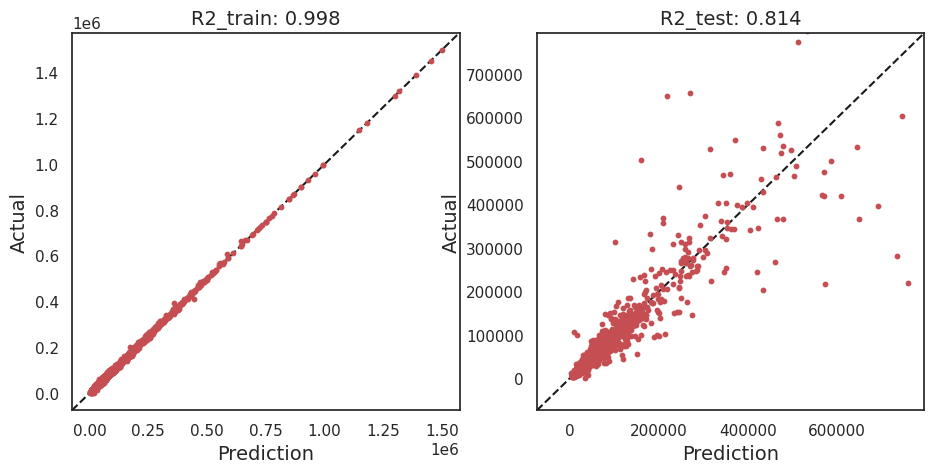

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_xgr)

A partir de los mejores valores del RandomSearch, fijamos la malla para el GridSearch que se usará afinando parámetros

In [ ]:
grid_xgr = {'xgr__max_depth': [11, 12, 13],
            'xgr__learning_rate': [0.15, 0.2, 0.25],
            'xgr__n_estimators': [270, 280, 290]
            }

##### MLP

También se procede igual

In [ ]:
best_randomsearch = all_rs_searchs["rs_mlp"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('mlp',
   MLPRegressor(alpha=0.1, early_stopping=True, hidden_layer_sizes=(30, 30),
                learning_rate_init=0.071, max_iter=3000))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'mlp': MLPRegressor(alpha=0.1, early_stopping=True, hidden_layer_sizes=(30, 30),
              learning_rate_init=0.071, max_iter=3000),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 369892542.6413522
MAE: 6568.596866579269
RMSE: 19232.590637804158


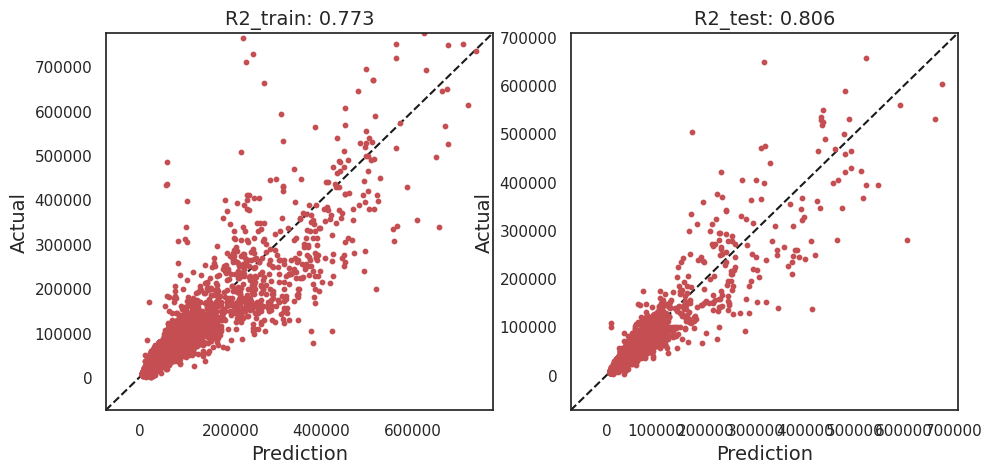

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_mlp)

In [ ]:
grid_mlp = {"mlp__hidden_layer_sizes": [(34,), (34,34),
                                        (36,),(36,36),
                                        (38,),(38,38), 
                                        (40,),(40,40)],
           "mlp__activation": ["relu"], 
           "mlp__solver": ["adam"], 
           "mlp__alpha": [0.05, 0.075, 0.1], 
           "mlp__validation_fraction": [0.1], 
           "mlp__early_stopping": [True],    
           "mlp__max_iter": [3000],
           "mlp__learning_rate_init":list(np.arange(0.01, 0.05, step = 0.01)) 
           }


##### RFR

Repetimos el mismo procedimiento que con el XGR

In [ ]:
best_randomsearch = all_rs_searchs["rs_rfr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('rfr',
   RandomForestRegressor(max_depth=40, max_features='sqrt', n_estimators=80))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'rfr': RandomForestRegressor(max_depth=40, max_features='sqrt', n_estimators=80),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out'

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 273133058.40114003
MAE: 3730.673832793431
RMSE: 16526.73768174288


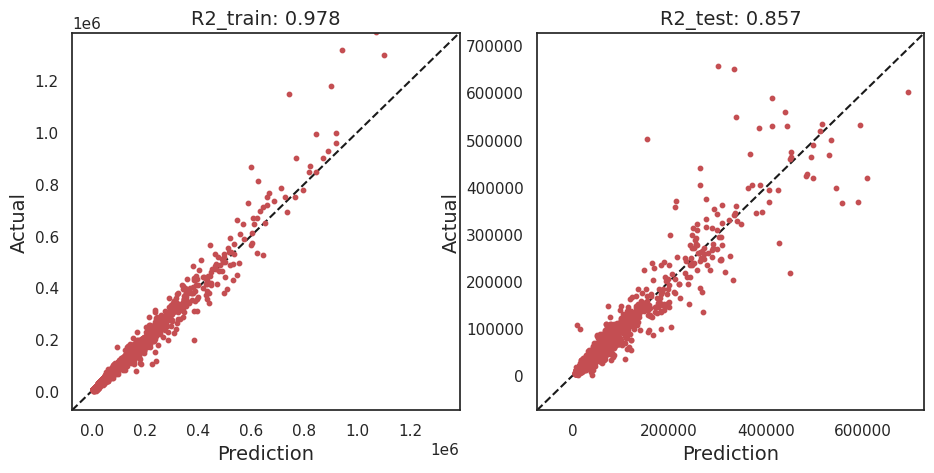

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_rfr)

In [ ]:
grid_rfr = {"rfr__n_estimators": [56, 58, 60, 62, 64, 66], 
            "rfr__max_depth": [71, 73, 75, 77, 79], 
            "rfr__max_features": ["sqrt", 3] 
                     }

##### KNR

Repetimos el mismo procedimiento de antes

In [ ]:
best_randomsearch = all_rs_searchs["rs_knr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('knr', KNeighborsRegressor(n_neighbors=9, weights='distance'))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'knr': KNeighborsRegressor(n_neighbors=9, weights='distance'),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': Standar

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 420664393.38825303
MAE: 5542.279781737143
RMSE: 20510.104665463143


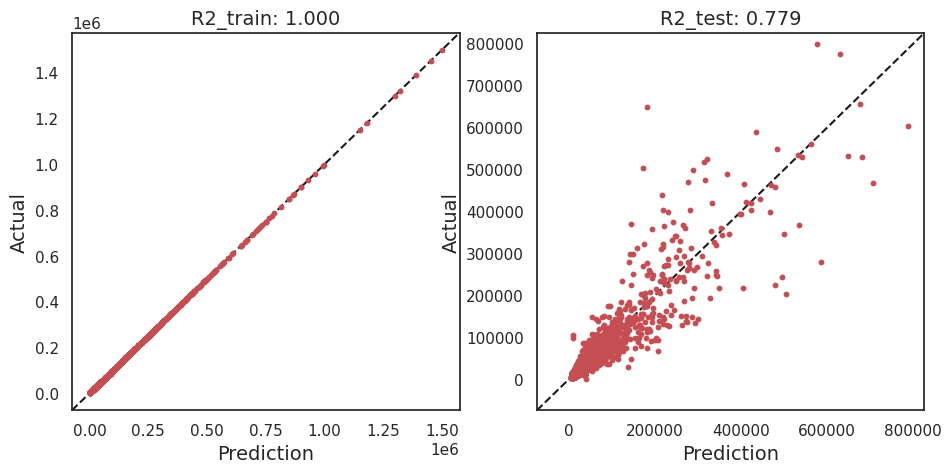

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_knr)

A partir de los mejores valores del RandomSearch, fijamos la malla para el GridSearch que se usará afinando parámetros

In [ ]:
grid_knr = {"knr__n_neighbors": list(np.arange(3, 12, step = 1)), 
                  "knr__weights": ["uniform","distance"]  
                  }

##### DTR

Repetimos el mismo procedimiento de antes

In [ ]:
best_randomsearch = all_rs_searchs["rs_dtr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('dtr', DecisionTreeRegressor(max_depth=18))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'dtr': DecisionTreeRegressor(max_depth=18),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': StandardScaler(),
 'prep__rescale numeric__co

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 490543289.5634847
MAE: 4944.861938433295
RMSE: 22148.211881853684


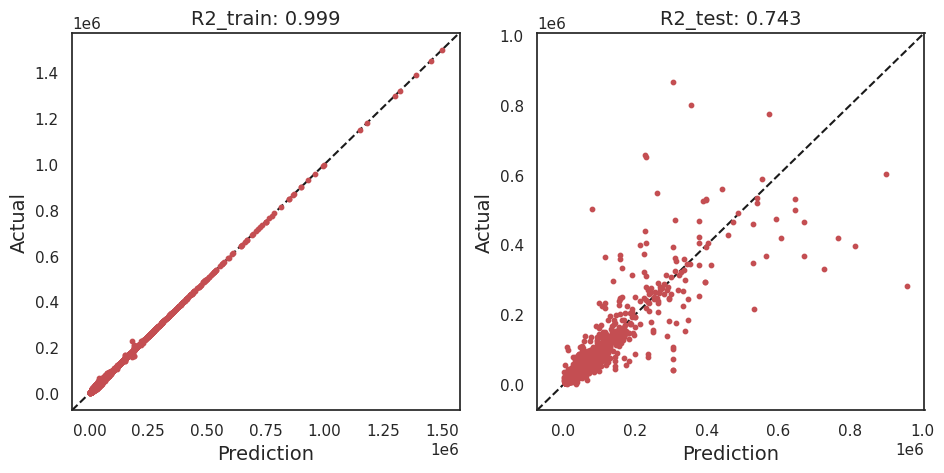

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_dtr)

A partir de los mejores valores del RandomSearch, fijamos la malla para el GridSearch que se usará afinando parámetros

In [ ]:
grid_dtr = {"dtr__max_depth": list(np.arange(10, 30, step = 1)) 
              }

### Finetuning de hiperparámetros

Para los 5 mejores modelos, en base a los resultados del RandomSearchCV, se hace un GridSearchCV con el objetivo de afinar los valores de los hiperparámetros

In [ ]:
gs_xgr = GridSearchCV(xgr, 
                    grid_xgr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_rfr = GridSearchCV(rfr, 
                    grid_rfr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_dtr = GridSearchCV(dtr, 
                    grid_dtr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_knr = GridSearchCV(knr, 
                    grid_knr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_mlp = GridSearchCV(mlp,
                      grid_mlp,
                      cv=5,
                      scoring='neg_mean_absolute_error',
                      verbose=1,
                      n_jobs=-1)


In [ ]:
all_gs_searchs = {"gs_xgr": gs_xgr,
                  "gs_rfr": gs_rfr,
                  "gs_dtr": gs_dtr,
                  "gs_knr": gs_knr,
                    "gs_mlp": gs_mlp
                    }

#### Entrenamiento de los modelos

In [ ]:
for nombre, grid_search in all_gs_searchs.items():
    start = time.time()
    print("Haciendo Grid Search de %s..." % nombre)
    grid_search.fit(X_train, y_train)
    stop = time.time()
    print(f"Tiempo de entrenamiento: {stop - start} s")

Haciendo Grid Search de gs_xgr...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[08:07:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tiempo de entrenamiento: 4095.948032140732 s
Haciendo Grid Search de gs_rfr...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Tiempo de entrenamiento: 277.53348302841187 s
Haciendo Grid Search de gs_dtr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 19.01068377494812 s
Haciendo Grid Search de gs_knr...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Tiempo de entrenamiento: 73.07830095291138 s
Haciendo Grid Search de gs_mlp...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Tiempo de entrenamiento: 2437.680510520935 s


#### Desempeño de los modelos

Evaluamos las métricas con el conjunto de test

##### XGR

In [ ]:
best_randomsearch = all_gs_searchs["gs_xgr"]
best_pipeline = best_randomsearch.best_estimator_

In [ ]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('xgr', XGBRegressor(learning_rate=0.15, max_depth=12, n_estimators=290))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo']),
                                 ('recode categorical',
                                

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 266556796.1846973
MAE: 3322.6873560426084
RMSE: 16326.56718923783


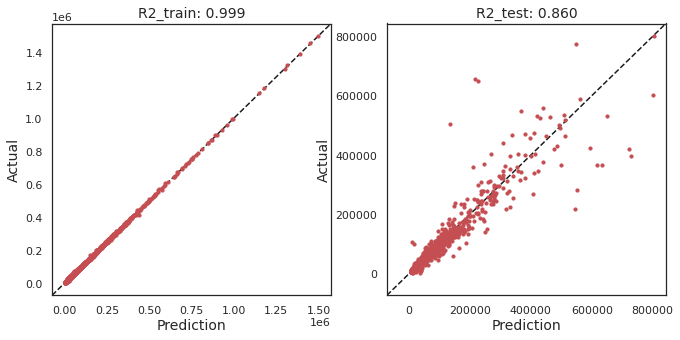

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_xgr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



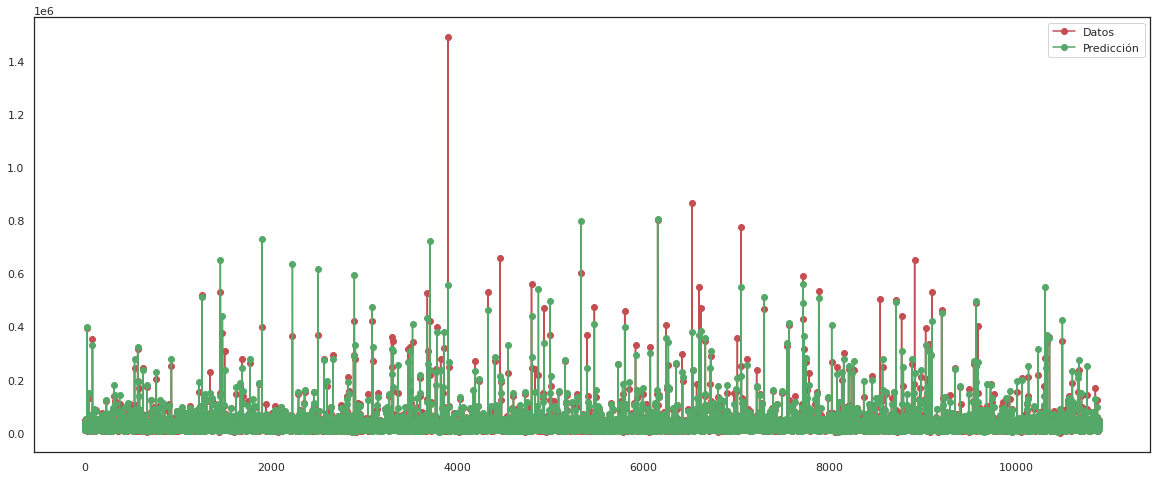

In [ ]:
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### RFR

In [ ]:
best_randomsearch = all_gs_searchs["gs_rfr"]
best_pipeline = best_randomsearch.best_estimator_

In [ ]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('rfr',
   RandomForestRegressor(max_depth=75, max_features='sqrt', n_estimators=64))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo']),
                                 ('recode categorical',
                    

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 280614418.62977093
MAE: 3570.6614018812993
RMSE: 16751.54973815172


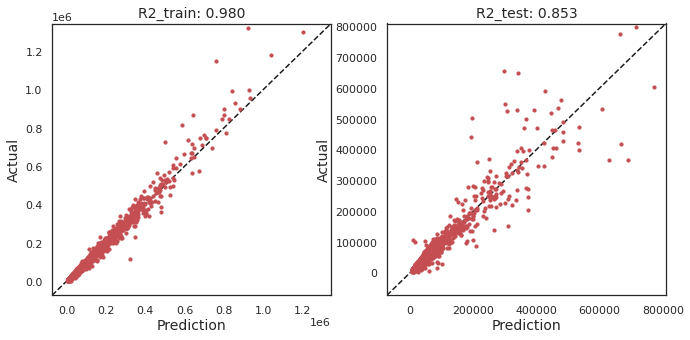

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_rfr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



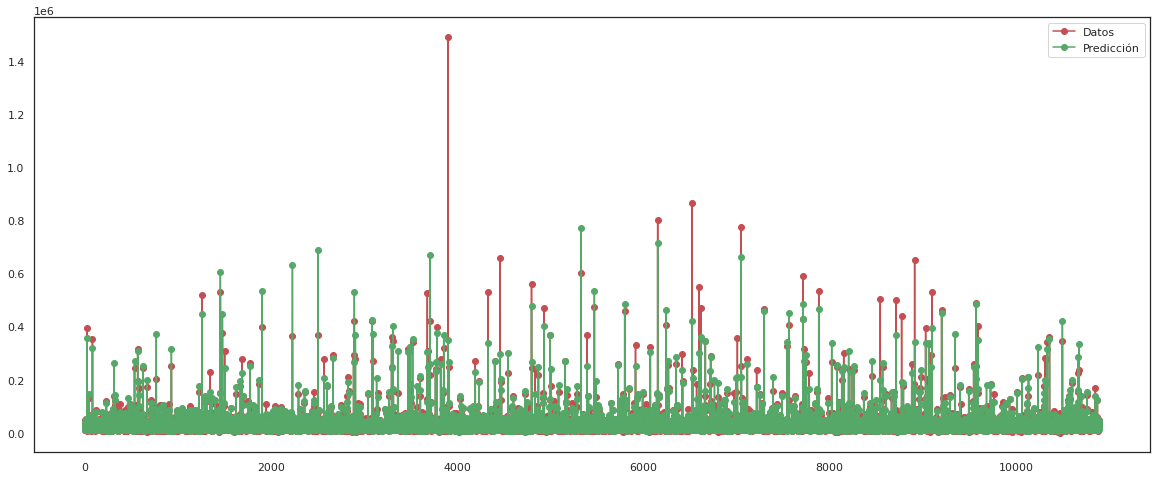

In [ ]:
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### MLP

In [ ]:
best_randomsearch = all_gs_searchs["gs_mlp"]
best_pipeline = best_randomsearch.best_estimator_

In [ ]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('mlp',
   MLPRegressor(alpha=0.075, early_stopping=True, hidden_layer_sizes=(36, 36),
                learning_rate_init=0.03, max_iter=3000))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo']),
                  

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 271993921.1592798
MAE: 3906.6089030388043
RMSE: 16492.238209511765


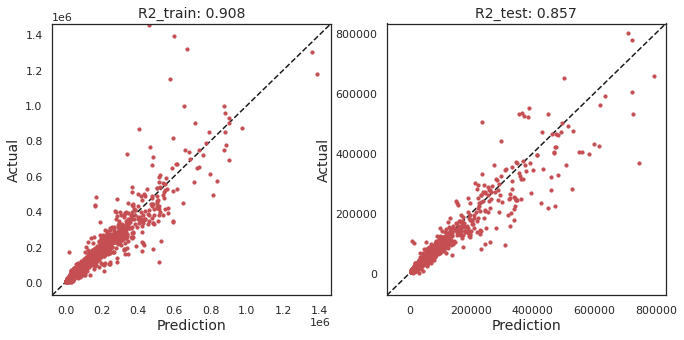

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_mlp)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



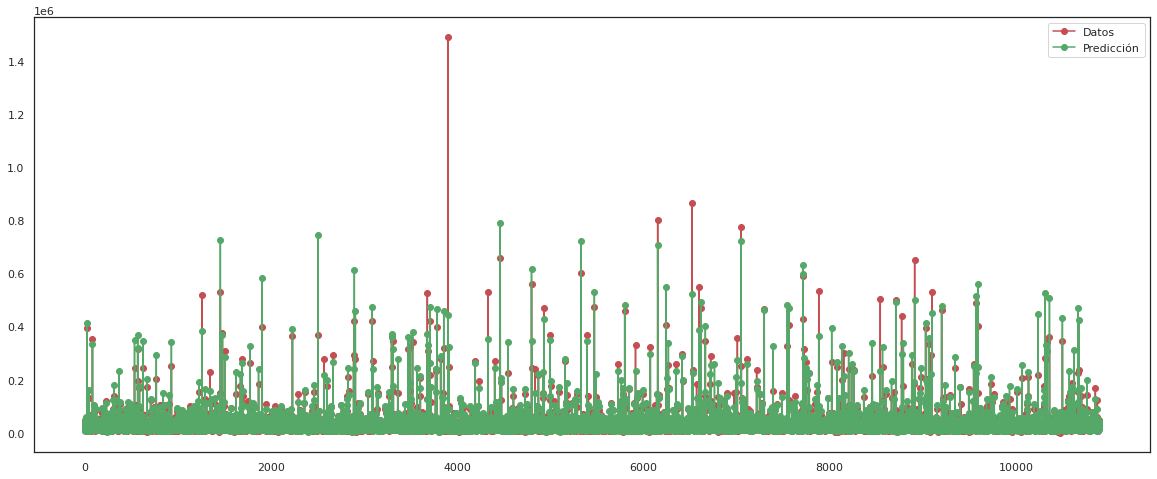

In [ ]:
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

El tiempo de ejecucción es muy alto. ¿Esto justifica reducir las características que aporten información?

##### KNR

In [ ]:
best_randomsearch = all_gs_searchs["gs_knr"]
best_pipeline = best_randomsearch.best_estimator_

In [ ]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('knr', KNeighborsRegressor(n_neighbors=6, weights='distance'))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo']),
                                 ('recode categorical',
                                  OneHotEn

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 286059518.41116357
MAE: 3834.7188018056404
RMSE: 16913.294132461706


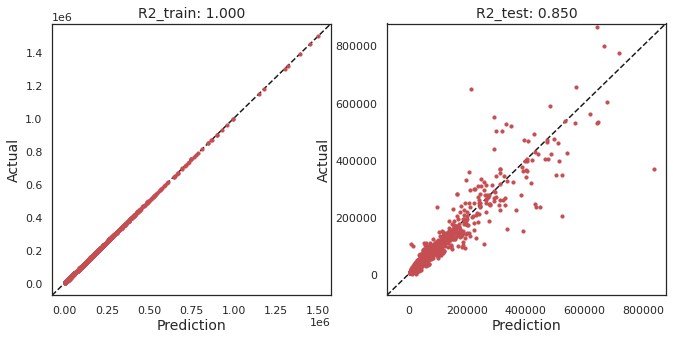

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_knr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



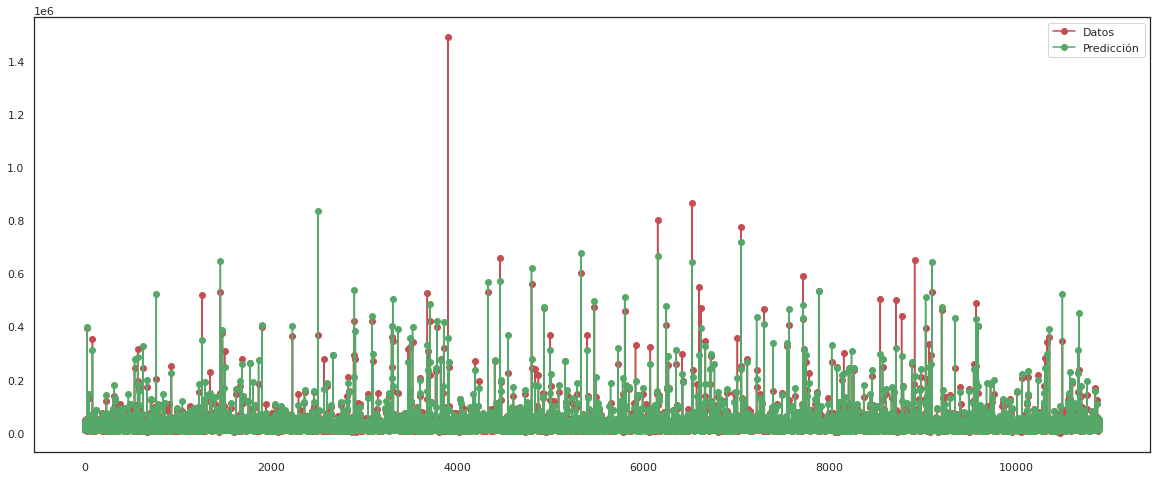

In [ ]:
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### DTR

In [ ]:
best_randomsearch = all_gs_searchs["gs_dtr"]
best_pipeline = best_randomsearch.best_estimator_

In [ ]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo']),
                                   ('recode categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['Marca', 'Modelo', 'Combustible', 'Cambio',
                                     'Provincia'])])),
  ('dtr', DecisionTreeRegressor(max_depth=27))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo']),
                                 ('recode categorical',
                                  OneHotEncoder(handle_unknow

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 545187875.7183331
MAE: 4424.203241988512
RMSE: 23349.25856892105


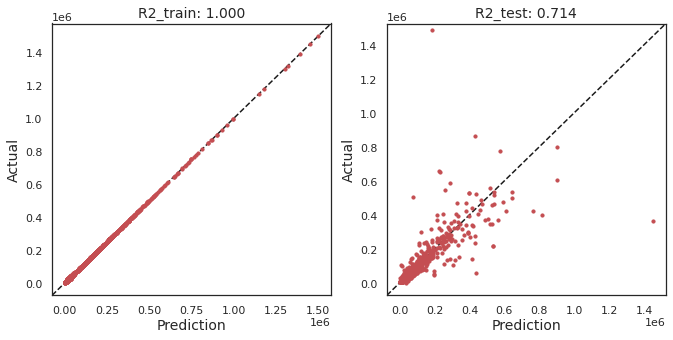

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_dtr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



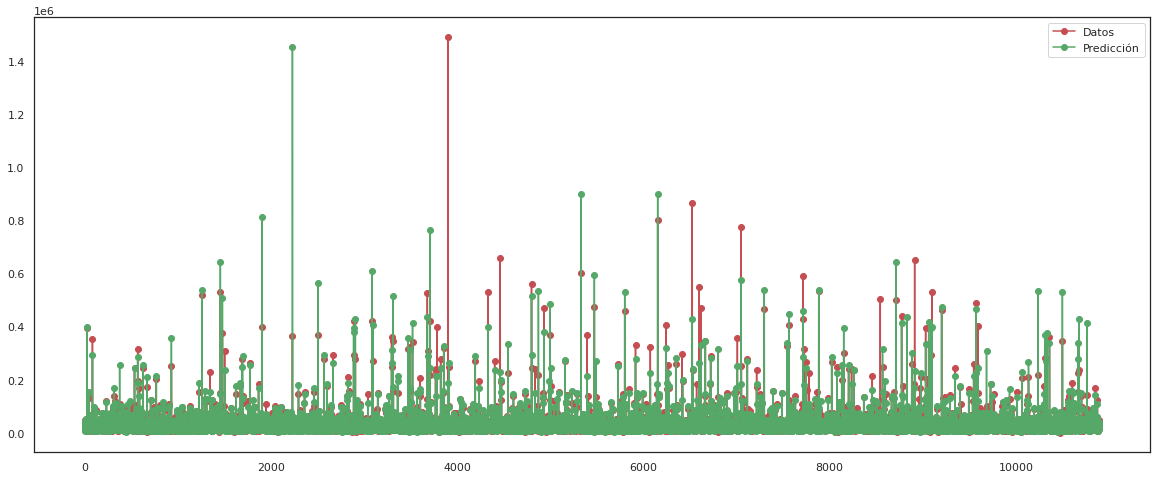

In [ ]:
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

## Modelado de predicción de precio usando FeatureSelect para usar sólo las características más importantes


Vamos a comprobar si es posible obtener buenos resultados en la predicción eliminando las características que tienen poca importancia.

Antes de hacer uso de FeatureSelector es necesario hacer la división entre train/test, para usar la selección de características en el conjunto de entrenamiento

No es preciso hace one hot enconding, ya que lo hace el propio método

### Preprocesado

Ya tenemos previamente separados el dataframe en dos conjuntos de datos, utilizando un 25% de los datos para test y el resto para entrenar

Cargamos FeatureSelector

In [ ]:
fs = FeatureSelector(data = X_train , labels = y_train)

In [ ]:
fs.identify_zero_importance(task = 'regression', eval_metric = 'l2', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[977]	valid_0's l2: 2.78689e+08	valid_0's l2: 2.78689e+08
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[540]	valid_0's l2: 2.56436e+08	valid_0's l2: 2.56436e+08
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[275]	valid_0's l2: 1.8259e+08	valid_0's l2: 1.8259e+08
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[295]	valid_0's l2: 4.09259e+08	valid_0's l2: 4.09259e+08
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[220]	valid_0's l2: 1.52542e+08	valid_0's l2: 1.52542e+08
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[664]	valid_0's l2: 3.79813e+08	valid_0's l2: 3.79813e+08
Training until vali

El número de variables con importancia cero cambia ligeramente en función del número de iteraciones (es un proceso con una cierta estocasticidad)

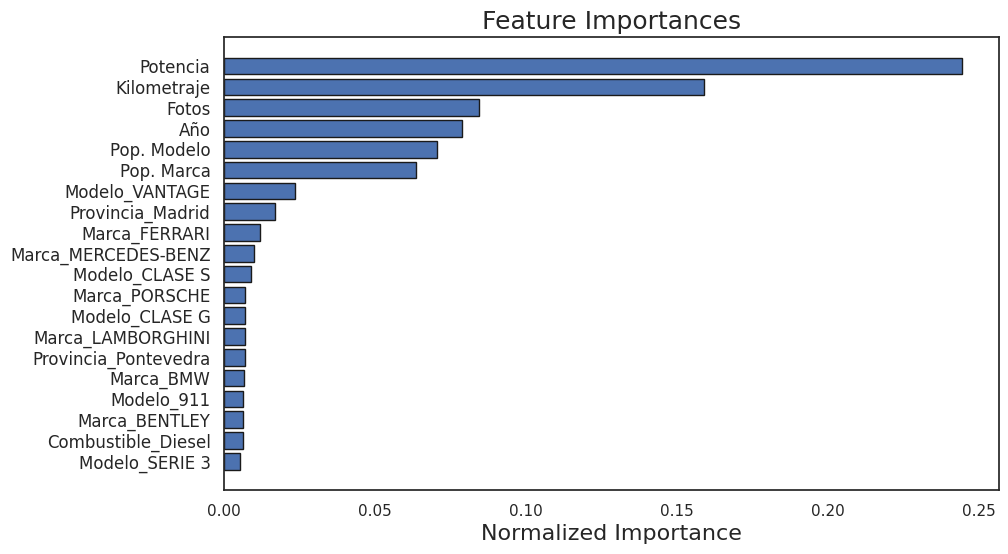

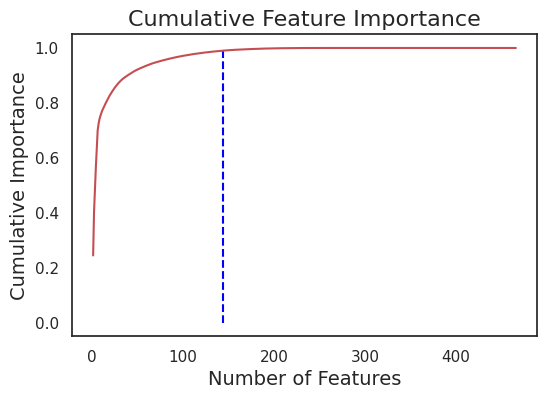

144 features required for 0.99 of cumulative importance


In [ ]:
sns.set(style="white")
fs.plot_feature_importances(threshold = 0.99, plot_n = 20)

In [ ]:
fs.feature_importances.head(30)

,feature,importance,normalized_importance,cumulative_importance
0,Potencia,3467.3,0.244348,0.244348
1,Kilometraje,2254.2,0.158858,0.403206
2,Fotos,1198.3,0.084447,0.487653
3,Año,1117.3,0.078739,0.566392
4,Pop. Modelo,1000.4,0.070500,0.636892
5,Pop. Marca,902.6,0.063608,0.700500
6,Modelo_VANTAGE,335.4,0.023636,0.724137
7,Provincia_Madrid,239.8,0.016899,0.741036
8,Marca_FERRARI,168.6,0.011882,0.752918
9,Marca_MERCEDES-BENZ,141.1,0.009944,0.762861


Se observa que la característica más importante es la potencia del vehículo, seguido del kilometraje. La popularidad de marca y modelo son menos relevantes que el número de fotografías. El año de matriculación es la variable numérica menos relevante.

También es posible ver las características que tienen poca relevancia (destacar que este método también es estocástico)

In [ ]:
fs.identify_low_importance(cumulative_importance = 0.99)

143 features required for cumulative importance of 0.99 after one hot encoding.
323 features do not contribute to cumulative importance of 0.99.



Es decir, que entre todas las caracaterísticas, entorno a 175 (según el método que se seleccione), se puede cubrir el 99% de la importancia acumulada.

Vemos las variables con poca importancia

In [ ]:
low_importance_features = fs.ops['low_importance']
print("Total de características con poca importancia:", len(low_importance_features))
print(low_importance_features[:292])

Total de características con poca importancia: 323
['Modelo_I30', 'Provincia_Tarragona', 'Modelo_CARENS', 'Modelo_IBIZA', 'Modelo_OCTAVIA', 'Provincia_Sevilla', 'Modelo_CAPTUR', 'Modelo_ECLIPSE', 'Modelo_A6', 'Provincia_Gipuzkoa', 'Combustible_GLP', 'Modelo_X2', 'Modelo_SERIE 6', 'Marca_MITSUBISHI', 'Marca_JEEP', 'Modelo_GIULIA', 'Modelo_CAYENNE', 'Modelo_PICANTO', 'Modelo_ASTRA', 'Modelo_DS 4', 'Modelo_CIVIC', 'Modelo_V40', 'Modelo_A4', 'Modelo_RENEGADE', 'Modelo_PULSAR', 'Modelo_FIESTA', 'Modelo_500', 'Modelo_KAROQ', 'Provincia_Granada', 'Provincia_Zaragoza', 'Modelo_KODIAQ', 'Modelo_DS 3', 'Modelo_TAYCAN', 'Modelo_V60', 'Marca_SUZUKI', 'Modelo_X1', 'Marca_KIA', 'Provincia_Málaga', 'Modelo_CONTINENTAL', 'Modelo_CORSA', 'Modelo_PANDA', 'Marca_HONDA', 'Marca_DS', 'Modelo_GOLF', 'Modelo_Q2', 'Marca_SEAT', 'Provincia_Ciudad Real', 'Modelo_CLASE CLA', 'Modelo_CX-3', 'Modelo_INSIGNIA', 'Modelo_A7', 'Modelo_S-MAX', 'Provincia_Ourense', 'Modelo_FABIA', 'Provincia_Zamora', 'Modelo_MACAN', 'Mo

Vemos también si hay variables con muy alta correlación, por si fuera necesario eliminarlas

In [ ]:
fs.identify_all(selection_params = {'missing_threshold': 0.6, 'correlation_threshold': 0.98, 
                                    'task': 'regression', 'eval_metric': 'l2', 
                                     'cumulative_importance': 0.99})

0 features with greater than 0.60 missing values.

0 features with a single unique value.

0 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[990]	valid_0's l2: 5.15761e+08	valid_0's l2: 5.15761e+08
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[108]	valid_0's l2: 1.70265e+08	valid_0's l2: 1.70265e+08
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[583]	valid_0's l2: 3.38093e+08	valid_0's l2: 3.38093e+08
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[268]	valid_0's l2: 5.27898e+08	valid_0's l2: 5.27898e+08
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[88]	valid_0's l2: 1.96967e+08	valid_0's l2: 1.96967e+08
Training until validati

Vemos que no hay variables con missing values ni correlacionadas.
Vamos a generar ahora un datraframe en le que se eliminen las variables que tienen poca o ninguna importancia

In [ ]:
df_2mano_pop_fs = fs.remove(methods = 'all', keep_one_hot = True)

['zero_importance', 'low_importance', 'missing', 'single_unique', 'collinear'] methods have been run

Removed 297 features.


Podemos ver la reducción de características que se ha realizado al usar FeatureSelect

In [ ]:
print( "Dataframe original con one hot encoding", df_2mano_pop_dummies.shape)
print( "Dataframe modificado con FeatureSelect", df_2mano_pop_fs.shape)

Dataframe original con one hot encoding (43589, 470)
Dataframe modificado con FeatureSelect (32691, 174)


Se observa que se ha pasado de 470 características a 158

Mostramos las características que finalmente hemos dejado

In [ ]:
lista = list(df_2mano_pop_fs.columns)
lista.insert(0, 'Precio')
originales = ['Marca', 'Modelo', 'Combustible', 'Cambio', 'Provincia']
lista = [e for e in lista if e not in originales]
print(lista)

['Precio', 'Marca_ALFA ROMEO', 'Marca_ASTON MARTIN', 'Marca_AUDI', 'Marca_BENTLEY', 'Marca_BMW', 'Marca_CITROEN', 'Marca_DACIA', 'Marca_FERRARI', 'Marca_FIAT', 'Marca_FORD', 'Marca_HYUNDAI', 'Marca_INFINITI', 'Marca_JAGUAR', 'Marca_KIA', 'Marca_LAMBORGHINI', 'Marca_LAND-ROVER', 'Marca_LEXUS', 'Marca_MASERATI', 'Marca_MERCEDES-BENZ', 'Marca_MINI', 'Marca_MITSUBISHI', 'Marca_NISSAN', 'Marca_OPEL', 'Marca_PEUGEOT', 'Marca_PORSCHE', 'Marca_RENAULT', 'Marca_SKODA', 'Marca_SSANGYONG', 'Marca_SUZUKI', 'Marca_TESLA', 'Marca_TOYOTA', 'Marca_VOLKSWAGEN', 'Marca_VOLVO', 'Modelo_2008', 'Modelo_208', 'Modelo_3008', 'Modelo_308', 'Modelo_5008', 'Modelo_508', 'Modelo_911', 'Modelo_A1', 'Modelo_A3', 'Modelo_A5', 'Modelo_A6', 'Modelo_AMG', 'Modelo_ASTRA', 'Modelo_ATECA', 'Modelo_AURIS', 'Modelo_AVENTADOR', 'Modelo_C-ELYSÉE', 'Modelo_C-HR', 'Modelo_CAPTUR', 'Modelo_CARENS', 'Modelo_CEED', 'Modelo_CIVIC', 'Modelo_CLASE A', 'Modelo_CLASE B', 'Modelo_CLASE C', 'Modelo_CLASE E', 'Modelo_CLASE G', 'Modelo_CL

Modificamos el dataframe original para quedarnos sólo con las columnas que tienen importancia y la variable objetivo

In [ ]:
df_2mano_pop_dummies = df_2mano_pop_dummies[lista]

Exportamos el dataframe para tener una copia

In [ ]:
df_2mano_pop_dummies.to_excel(path+"df_2mano_pop_dummies.xlsx", header=True)

In [ ]:
#df_2mano_pop_dummies = pd.read_excel(path+'df_2mano_pop_dummies.xlsx', index_col=[0])
#Para poder trabajar en local

Separamos dos conjuntos de datos, utilizando un 25% de los datos para test y el resto para entrenar

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df_2mano_pop_dummies.drop(columns = target),
                                        df_2mano_pop_dummies[target],
                                        test_size=0.25,
                                        random_state = 123
                                    )

print("Dimensiones del dataframe original",df_2mano_pop_dummies.shape)
print("Dimensiones del dataframe sin variable objetivo para train", X_train.shape)
print("variable objetivo para train", y_train.shape)
print("Dimensiones del dataframe sin variable objetivo para test", X_test.shape)
print("variable objetivo para test", y_test.shape)

Dimensiones del dataframe original (43589, 170)
Dimensiones del dataframe sin variable objetivo para train (32691, 169)
variable objetivo para train (32691,)
Dimensiones del dataframe sin variable objetivo para test (10898, 169)
variable objetivo para test (10898,)


Se hace un reset de índices

In [ ]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

Creamos un transformer para estandarizar las variables numéricas (ya no hay variables categoricas al haber hecho el one hot enconding previamente para el dataframe df_2mano_pop_dummies)

In [ ]:
data_transformer = ColumnTransformer(
  transformers = [
    ('rescale numeric', preprocessing.StandardScaler(), num_feat),    
    ])

### Creación del pipeline con los modelos

Creamos el pipeline que aplica la transformación y asigna el modelo a usar.
Realmente, para los modelos tipo árbol (dtr, rfr y gbr) no sería necesario estandarizar (pero tampoco pasa nada si se hace)

In [ ]:
dtr = Pipeline(steps = [("prep", data_transformer), ('dtr', DecisionTreeRegressor())])
rfr = Pipeline(steps = [("prep", data_transformer), ('rfr', RandomForestRegressor())])
gbr = Pipeline(steps = [("prep", data_transformer), ('gbr', GradientBoostingRegressor())])
lr = Pipeline(steps=[("prep", data_transformer), ("lr",LinearRegression())])
ridge = Pipeline(steps=[("prep", data_transformer), ("ridge",Ridge())])
lasso = Pipeline(steps=[("prep", data_transformer), ("lasso",Lasso())])
knr = Pipeline(steps=[("prep", data_transformer), ("knr",KNeighborsRegressor())])
#svr = Pipeline(steps=[("prep", data_transformer), ("svr",SVR())]) No acaba nunca de coverger
lsvr= Pipeline(steps=[("prep", data_transformer), ("lsvr",LinearSVR())])
mlp = Pipeline(steps=[("prep", data_transformer), ("mlp",MLPRegressor())])
xgr = Pipeline(steps=[("prep", data_transformer), ("xgr",XGBRegressor())])

### Búsqueda inicial de hiperparámetros: RandomSearch

Se utiliza inicialmente la técnica de RandomSearchCV, para buscar unos parámetros iniciales que luego se puedan afinar con GridSearchCV

In [ ]:
# Arbol de decisión
grid_rs_dtr = {"dtr__max_depth": list(np.arange(2, 20, step = 2)) 
              }
# Random Forest
grid_rs_rfr = {"rfr__n_estimators": list(np.arange(10, 100, step = 10)), 
                     
                     "rfr__max_depth": list(np.arange(10, 50, step = 10)), 
                      
                     "rfr__max_features": ["sqrt", 3, 4] 
                     }
# Gradient Boosting
grid_rs_gbr = {"gbr__loss": ["squared_error"],
                          "gbr__learning_rate": list(np.arange(0.05, 1, step = 0.1)), 
                          
                          "gbr__n_estimators": list(np.arange(5, 30, step = 5)), 
                          
                          "gbr__max_depth": list(np.arange(15, 30, step = 5)), 
                          
                          "gbr__subsample": list(np.arange(0.5, 1, step = 0.1)), 
                          
                          "gbr__max_features": ["sqrt", 4, 8], 
                          }
# Ridge
grid_rs_ridge= {'ridge__alpha': list(np.arange(0.1, 5, step = 0.2))}

# Lasso
grid_rs_lasso= {'lasso__alpha': list(np.arange(0.1, 5, step = 0.2))}

# KNeighbors
grid_rs_knr = {"knr__n_neighbors": list(np.arange(1, 15, step = 2)), 
                  "knr__weights": ["uniform","distance"]  
                  }

# Linear Suppport Vector Machine 
grid_rs_lsvr={"lsvr__tol":[0.001,0.0001], "lsvr__C": [0.1, 5.0, 50.0]}

# Multi layer perceptron
grid_rs_mlp = {"mlp__hidden_layer_sizes": [(4,),             
                                        (4,4),           
                                        (30,),          
                                        (30,30)],
            
           "mlp__activation": ["relu"], 
            
           "mlp__solver": ["adam"], 
            
           "mlp__alpha": [0.0, 0.1], 
            
           "mlp__validation_fraction": [0.1], 
           "mlp__early_stopping": [True],    
           "mlp__max_iter": [3000],
            
           "mlp__learning_rate_init": list(np.arange(0.001, 0.1, step = 0.01)) 
           }

# XGBRegressor

grid_rs_xgr = {'xgr__max_depth': list(np.arange(1, 10, step = 1)),
            'xgr__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
            'xgr__n_estimators': list(np.arange(50, 200, step = 20))
            }

In [ ]:
rs_dtr = RandomizedSearchCV(dtr, 
                    grid_rs_dtr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)
rs_rfr = RandomizedSearchCV(rfr, 
                    grid_rs_rfr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_gbr = RandomizedSearchCV(gbr, 
                    grid_rs_gbr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_ridge = RandomizedSearchCV(ridge, 
                    grid_rs_ridge,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_lasso = RandomizedSearchCV(lasso, 
                    grid_rs_lasso,
                    n_iter = 20, 
                    cv=3, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_knr = RandomizedSearchCV(knr, 
                    grid_rs_knr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_mlp = RandomizedSearchCV(mlp,
                      grid_rs_mlp,
                      n_iter = 20,
                      cv=5,
                      scoring='neg_mean_absolute_error',
                      verbose=1,
                      n_jobs=-1)

rs_lsvr = RandomizedSearchCV(lsvr,
                    grid_rs_lsvr,
                    n_iter = 20,
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_xgr = RandomizedSearchCV(xgr, 
                    grid_rs_xgr,
                    n_iter = 20, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)
rs_lr = GridSearchCV(lr,
                    param_grid={},
                    cv=10, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

Se incluye tambien la regresión lineal, teniendo en cuenta que no tiene hiperparámetros

In [ ]:
all_rs_searchs = {"rs_dtr":rs_dtr,
                    "rs_rfr":rs_rfr,
                    "rs_gbr":rs_gbr,
                    "rs_ridge":rs_ridge,
                    "rs_lasso":rs_lasso,
                    "rs_knr":rs_knr,
                    "rs_lsvr": rs_lsvr,
                    "rs_mlp":rs_mlp,
                    "rs_xgr": rs_xgr,
                    "rs_lr": rs_lr
                    }

#### Entrenamiento de los modelos

Se procede a entrenar los modelos para el RandomSearch previsto

In [ ]:
for nombre, grid_search in all_rs_searchs.items():
    start = time.time()
    print("Haciendo Random Search de %s..." % nombre)
    grid_search.fit(X_train, y_train)
    stop = time.time()
    print(f"Tiempo de entrenamiento: {stop - start} s")

Haciendo Random Search de rs_dtr...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.



Tiempo de entrenamiento: 3.7616515159606934 s
Haciendo Random Search de rs_rfr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 41.17945575714111 s
Haciendo Random Search de rs_gbr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


45 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 586, in fit
    n_stages = self._fit_stages(
  File "/usr/local/lib/python3.8/dist-packages

Tiempo de entrenamiento: 10.99483847618103 s
Haciendo Random Search de rs_ridge...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 3.641380786895752 s
Haciendo Random Search de rs_lasso...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tiempo de entrenamiento: 2.250715732574463 s
Haciendo Random Search de rs_knr...
Fitting 5 folds for each of 14 candidates, totalling 70 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 14 is smaller than n_iter=20. Running 14 iterations. For exhaustive searches, use GridSearchCV.



Tiempo de entrenamiento: 4.4430365562438965 s
Haciendo Random Search de rs_lsvr...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.



Tiempo de entrenamiento: 1.257369041442871 s
Haciendo Random Search de rs_mlp...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 261.92954659461975 s
Haciendo Random Search de rs_xgr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[09:08:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tiempo de entrenamiento: 41.2160804271698 s
Haciendo Random Search de rs_lr...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Tiempo de entrenamiento: 0.47174859046936035 s


Se evaluan el desempeño de los modelos tras usar RandomSearch, obteniendo la mejor puntuación de cada modelo. Para eso, hacemos pares modelo-puntuación y lo ordenamos (haciendo uso de un dataframe)

#### Desempeño de los modelos

In [ ]:
best_score_rs = [(nombre_modelo, grid_search.best_score_)
                                  for nombre_modelo, grid_search           
                                  in all_rs_searchs.items()]

best_score_rs_df = pd.DataFrame(best_score_rs, 
                                columns=["RandomSearchCV", "Best score"]).sort_values(by="Best score", ascending=False)

best_score_rs_df

,RandomSearchCV,Best score
1,rs_rfr,-4105.623375
8,rs_xgr,-4286.062140
2,rs_gbr,-4683.975165
0,rs_dtr,-5288.511678
5,rs_knr,-5970.160497
7,rs_mlp,-6754.288992
6,rs_lsvr,-8370.362889
9,rs_lr,-11330.194532
3,rs_ridge,-11331.144513
4,rs_lasso,-11331.598041


Seleccionamos los 5 mejores modelos, a los que le haremos un GridSearch para afinar más los hiperparámetros. Para eso, vemos los valores de los mejores hiperparámetros obtenidos y vamos creando las mallas (grid) donde afinar los valores

##### RFR

Repetimos el mismo procedimiento que con el XGR

In [ ]:
best_randomsearch = all_rs_searchs["rs_rfr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('rfr',
   RandomForestRegressor(max_depth=40, max_features=3, n_estimators=90))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'rfr': RandomForestRegressor(max_depth=40, max_features=3, n_estimators=90),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 '

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 286199272.6123964
MAE: 3719.4580992009182
RMSE: 16917.42511768255


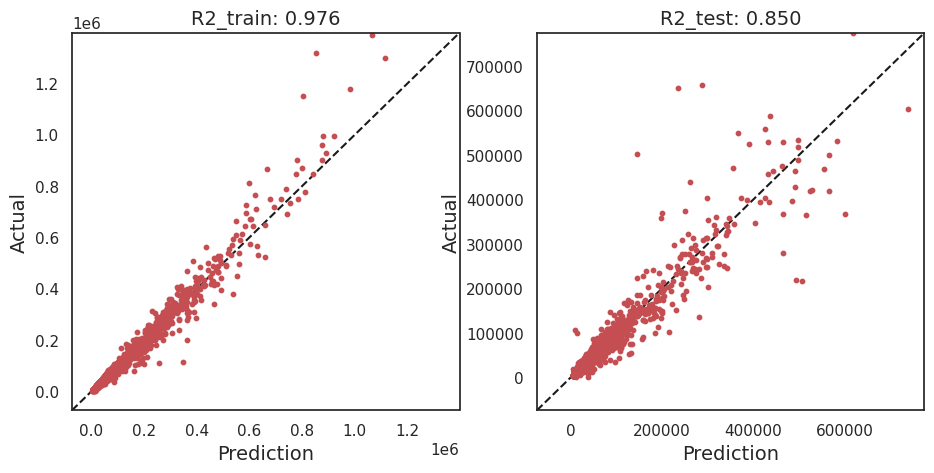

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_rfr)

In [ ]:
grid_rfr = {"rfr__n_estimators": [95, 98, 101], 
            "rfr__max_depth": [52, 55, 58], 
            "rfr__max_features": ["sqrt", 3, 4] 
                     }

##### XGR

Vemos las métricas de error y lo bueno que es el ajuste con los hiperparámetros resultantes del RandomSearch

In [ ]:
best_randomsearch = all_rs_searchs["rs_xgr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('xgr', XGBRegressor(learning_rate=0.3, max_depth=9, n_estimators=150))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'xgr': XGBRegressor(learning_rate=0.3, max_depth=9, n_estimators=150),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale n

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 389666615.12435174
MAE: 4035.589554737502
RMSE: 19739.97505379254


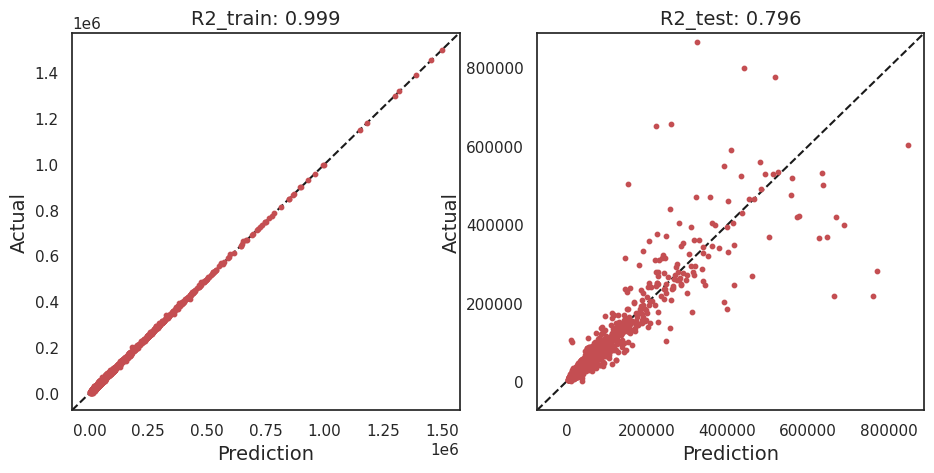

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_xgr)

A partir de los mejores valores del RandomSearch, fijamos la malla para el GridSearch que se usará afinando parámetros

In [ ]:
grid_xgr = {'xgr__max_depth': [9, 10, 11],
            'xgr__learning_rate': [0.1, 0.15, 0.2],
            'xgr__n_estimators': [430, 450, 470]
            }

##### GBR

Repetimos el mismo procedimiento de antes

In [ ]:
best_randomsearch = all_rs_searchs["rs_gbr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('gbr',
   GradientBoostingRegressor(learning_rate=0.35000000000000003, max_depth=20,
                             max_features='sqrt', n_estimators=15, subsample=0.7))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'gbr': GradientBoostingRegressor(learning_rate=0.35000000000000003, max_depth=20,
                           max_features='sqrt', n_estimators=15, subsample=0.7),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numer

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 342479639.01367545
MAE: 4198.438833956401
RMSE: 18506.205419093225


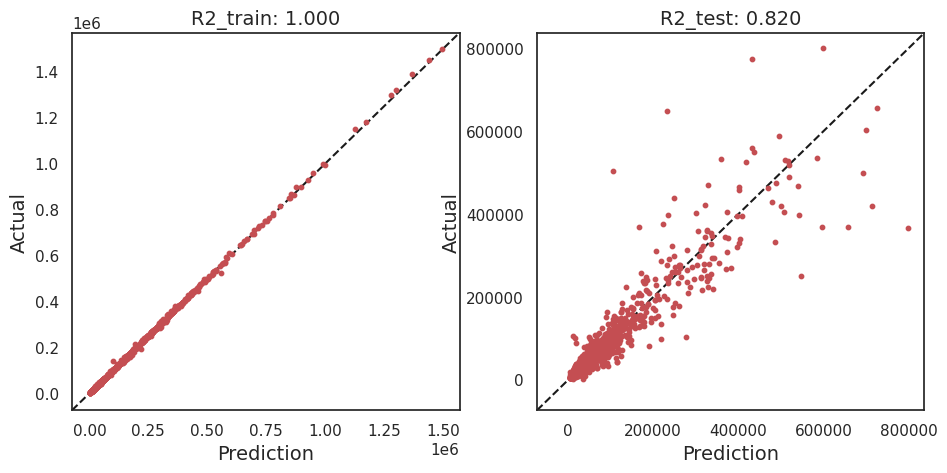

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_gbr)

A partir de los mejores valores del RandomSearch, fijamos la malla para el GridSearch que se usará afinando parámetros

In [ ]:
grid_gbr = {"gbr__loss": ["squared_error"],
                "gbr__learning_rate": [0.05, 0.07, 0.09],           
                "gbr__n_estimators": [100, 105, 110], 
                "gbr__max_depth": [10, 15, 20], 
                "gbr__subsample": [0.85], 
                "gbr__max_features": [2, 3], 
                }

##### DTR

También se procede igual

In [ ]:
best_randomsearch = all_rs_searchs["rs_dtr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('dtr', DecisionTreeRegressor(max_depth=16))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'dtr': DecisionTreeRegressor(max_depth=16),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': StandardScaler(),
 'prep__rescale numeric__co

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 472213394.36544585
MAE: 4841.946172616844
RMSE: 21730.471563347306


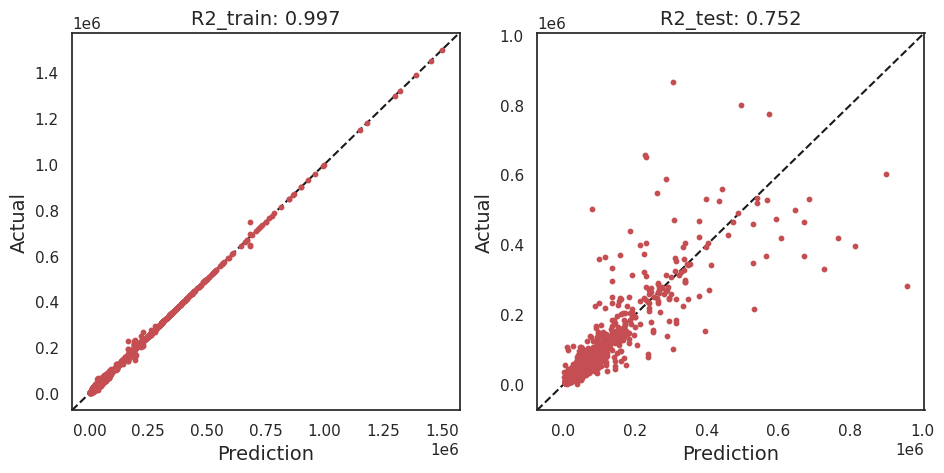

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_dtr)

In [ ]:
grid_dtr = {"dtr__max_depth": list(np.arange(2, 30, step = 1))
           }

##### KNR

Repetimos el mismo procedimiento de antes

In [ ]:
best_randomsearch = all_rs_searchs["rs_knr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('knr', KNeighborsRegressor(n_neighbors=9, weights='distance'))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'knr': KNeighborsRegressor(n_neighbors=9, weights='distance'),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': Standar

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 420664393.38825303
MAE: 5542.279781737143
RMSE: 20510.104665463143


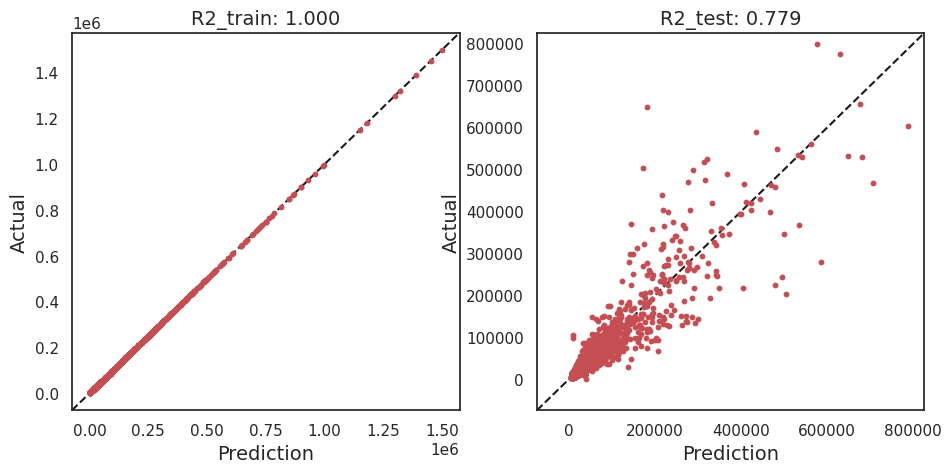

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, rs_knr)

A partir de los mejores valores del RandomSearch, fijamos la malla para el GridSearch que se usará afinando parámetros

In [ ]:
grid_knr = {"knr__n_neighbors": list(np.arange(5, 15, step = 1)), 
                  "knr__weights": ["uniform","distance"]  
                  }

### Finetuning de hiperparámetros

Para los 5 mejores modelos, en base a los resultados del RandomSearchCV, se hace un GridSearchCV con el objetivo de afinar los valores de los hiperparámetros

In [ ]:
gs_xgr = GridSearchCV(xgr, 
                    grid_xgr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_rfr = GridSearchCV(rfr, 
                    grid_rfr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_gbr = GridSearchCV(gbr, 
                    grid_gbr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_knr = GridSearchCV(knr, 
                    grid_knr, 
                    cv=5, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

gs_dtr = GridSearchCV(dtr,
                      grid_dtr,
                      cv=5,
                      scoring='neg_mean_absolute_error',
                      verbose=1,
                      n_jobs=-1)


In [ ]:
all_gs_searchs = {
                  "gs_rfr": gs_rfr,
                  "gs_xgr": gs_xgr,
                  "gs_gbr": gs_gbr,
                  "gs_dtr": gs_dtr,
                  "gs_knr": gs_knr
                    }

#### Entrenamiento de los modelos

In [ ]:
for nombre, grid_search in all_gs_searchs.items():
    start = time.time()
    print("Haciendo Grid Search de %s..." % nombre)
    grid_search.fit(X_train, y_train)
    stop = time.time()
    print(f"Tiempo de entrenamiento: {stop - start} s")

Haciendo Grid Search de gs_rfr...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Tiempo de entrenamiento: 98.2805802822113 s
Haciendo Grid Search de gs_xgr...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[09:15:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tiempo de entrenamiento: 294.105996131897 s
Haciendo Grid Search de gs_gbr...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Tiempo de entrenamiento: 190.8440456390381 s
Haciendo Grid Search de gs_dtr...
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Tiempo de entrenamiento: 7.442566394805908 s
Haciendo Grid Search de gs_knr...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de entrenamiento: 6.872102737426758 s


#### Desempeño de los modelos

Evaluamos las métricas con el conjunto de test

##### RFR

In [ ]:
best_randomsearch = all_gs_searchs["gs_rfr"]
best_pipeline = best_randomsearch.best_estimator_

In [ ]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('rfr',
   RandomForestRegressor(max_depth=58, max_features=3, n_estimators=101))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'rfr': RandomForestRegressor(max_depth=58, max_features=3, n_estimators=101),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,


In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 286452711.7085668
MAE: 3688.699145309695
RMSE: 16924.913935041644


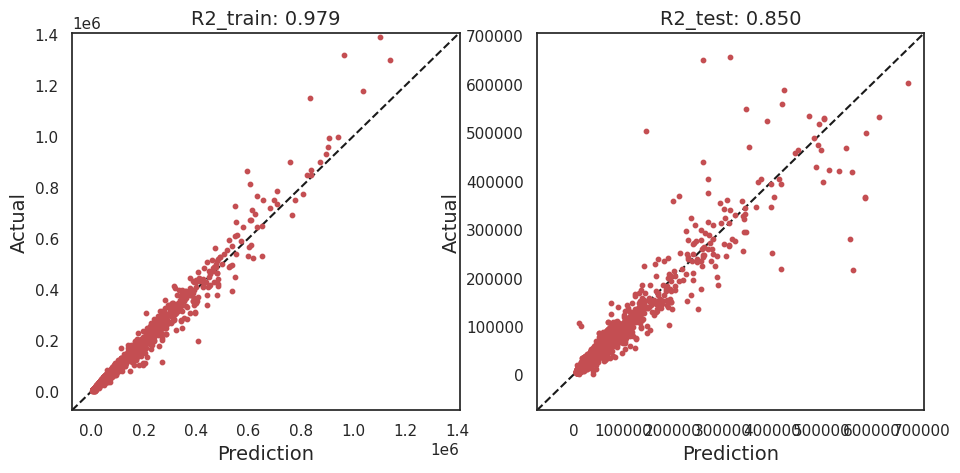

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_rfr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



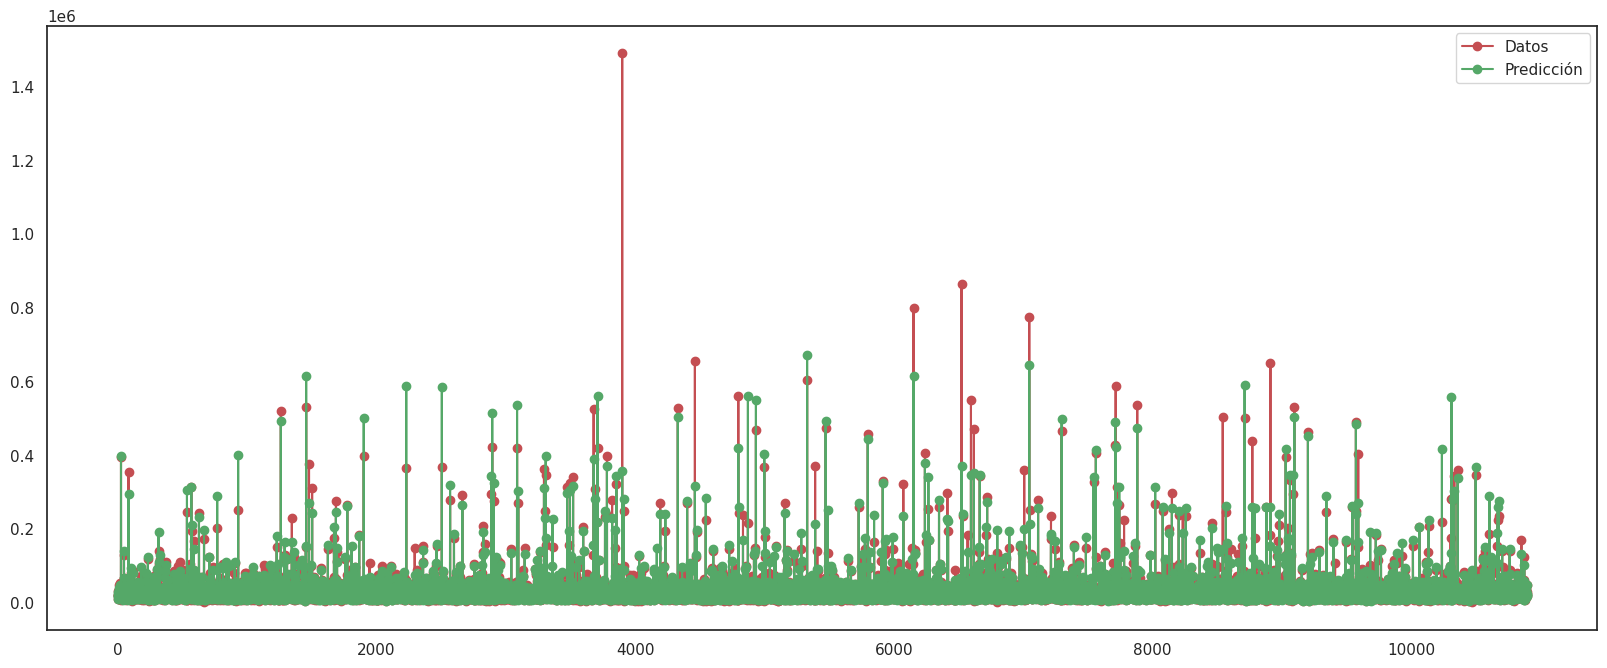

In [ ]:
sns.set(style="white")
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### XGR

In [ ]:
best_randomsearch = all_gs_searchs["gs_xgr"]
best_pipeline = best_randomsearch.best_estimator_

In [ ]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('xgr', XGBRegressor(learning_rate=0.15, max_depth=10, n_estimators=470))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'xgr': XGBRegressor(learning_rate=0.15, max_depth=10, n_estimators=470),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__resca

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 362066779.4755014
MAE: 3859.560108506148
RMSE: 19028.052435167963


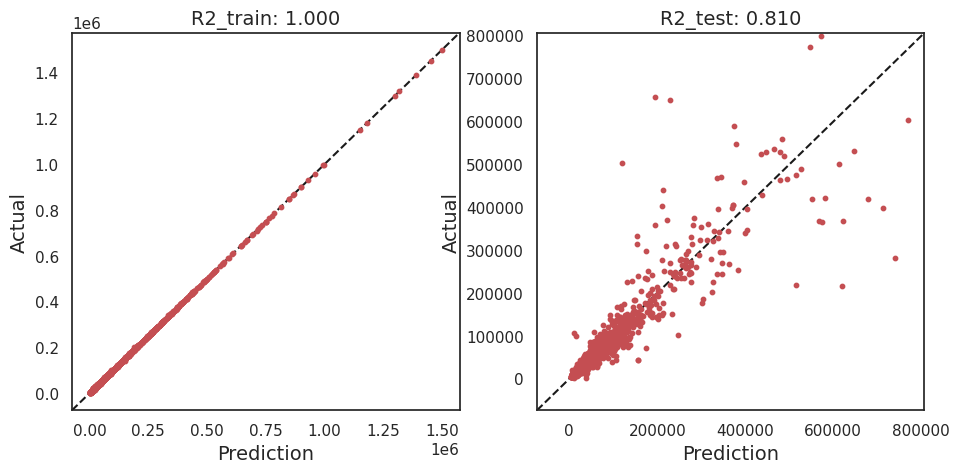

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_xgr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



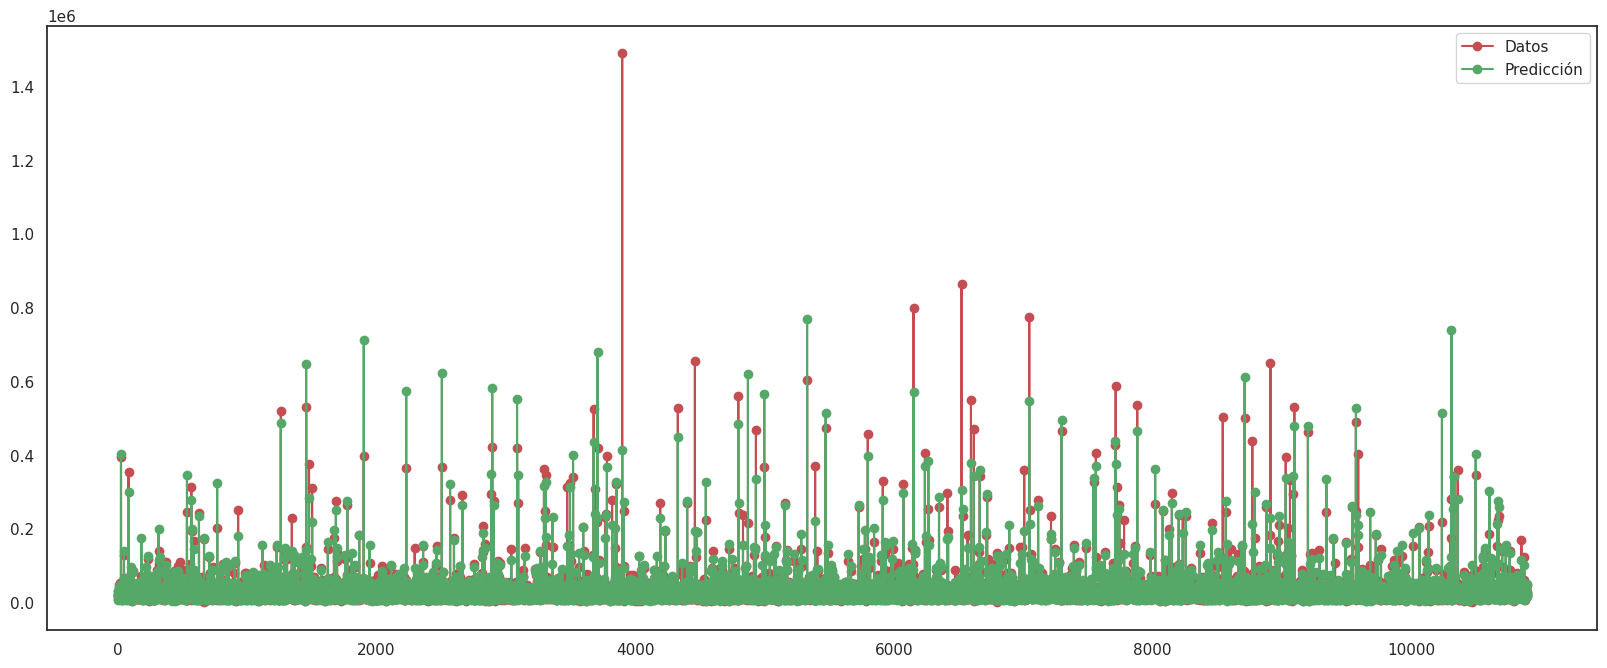

In [ ]:
sns.set(style="white")
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### GBR

In [ ]:
best_randomsearch = all_gs_searchs["gs_gbr"]
best_pipeline = best_randomsearch.best_estimator_

In [ ]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('gbr',
   GradientBoostingRegressor(learning_rate=0.05, max_depth=20, max_features=3,
                             n_estimators=105, subsample=0.85))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'gbr': GradientBoostingRegressor(learning_rate=0.05, max_depth=20, max_features=3,
                           n_estimators=105, subsample=0.85),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año',

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 326416777.4992955
MAE: 3739.538566430666
RMSE: 18067.00798414877


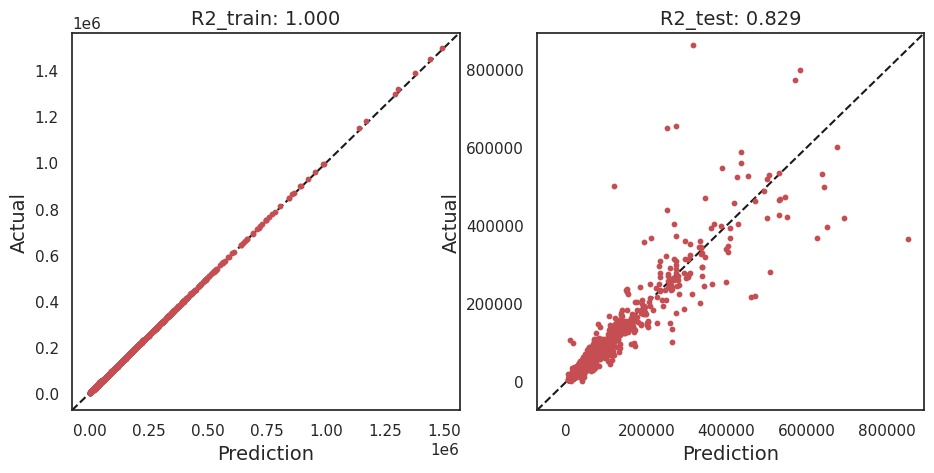

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_gbr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



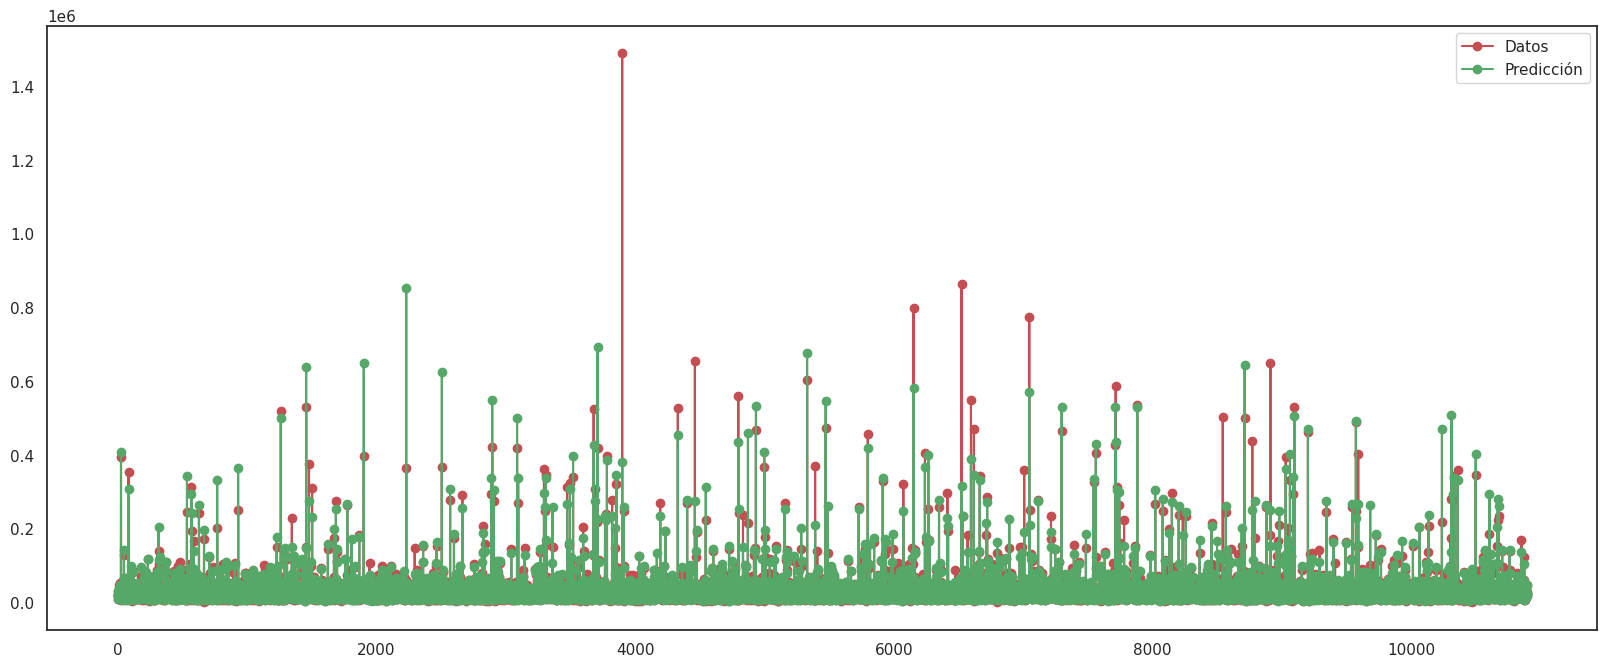

In [ ]:
sns.set(style="white")
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### DTR

In [ ]:
best_randomsearch = all_gs_searchs["gs_dtr"]
best_pipeline = best_randomsearch.best_estimator_

In [ ]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('dtr', DecisionTreeRegressor(max_depth=18))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'dtr': DecisionTreeRegressor(max_depth=18),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': StandardScaler(),
 'prep__rescale numeric__co

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 472822786.7325052
MAE: 4908.1952568784045
RMSE: 21744.48865189764


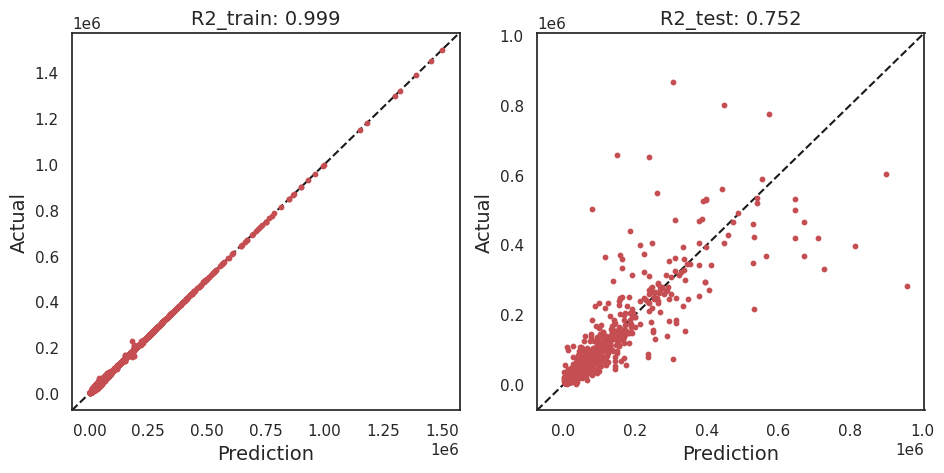

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_dtr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



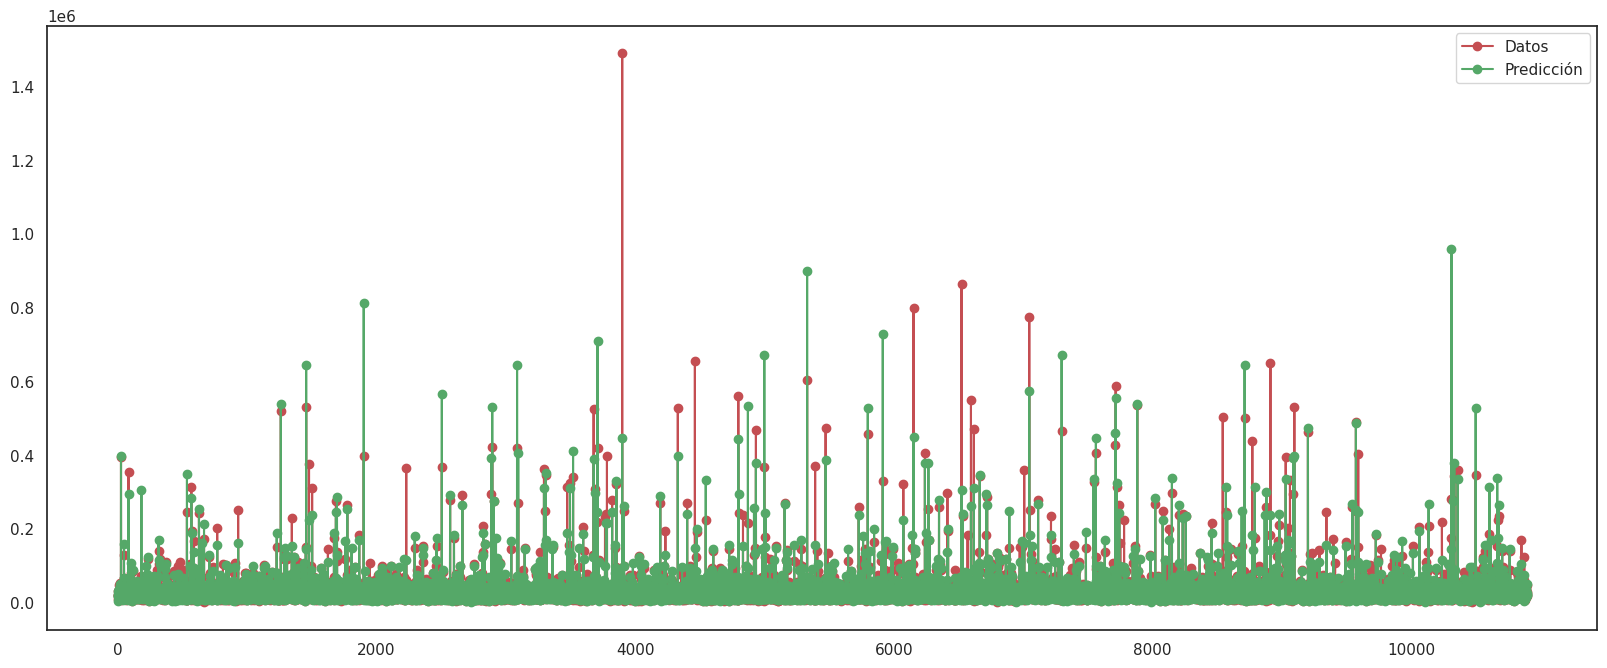

In [ ]:
sns.set(style="white")
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()

##### KBR

In [ ]:
best_randomsearch = all_gs_searchs["gs_knr"]
best_pipeline = best_randomsearch.best_estimator_

In [ ]:
best_pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                    ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                     'Pop. Marca', 'Pop. Modelo'])])),
  ('knr', KNeighborsRegressor(n_neighbors=10, weights='distance'))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('rescale numeric', StandardScaler(),
                                  ['Año', 'Kilometraje', 'Potencia', 'Fotos',
                                   'Pop. Marca', 'Pop. Modelo'])]),
 'knr': KNeighborsRegressor(n_neighbors=10, weights='distance'),
 'prep__n_jobs': None,
 'prep__remainder': 'drop',
 'prep__sparse_threshold': 0.3,
 'prep__transformer_weights': None,
 'prep__transformers': [('rescale numeric',
   StandardScaler(),
   ['Año', 'Kilometraje', 'Potencia', 'Fotos', 'Pop. Marca', 'Pop. Modelo'])],
 'prep__verbose': False,
 'prep__verbose_feature_names_out': True,
 'prep__rescale numeric': Stand

In [ ]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 420600029.69785285
MAE: 5531.506616521027
RMSE: 20508.53553274472


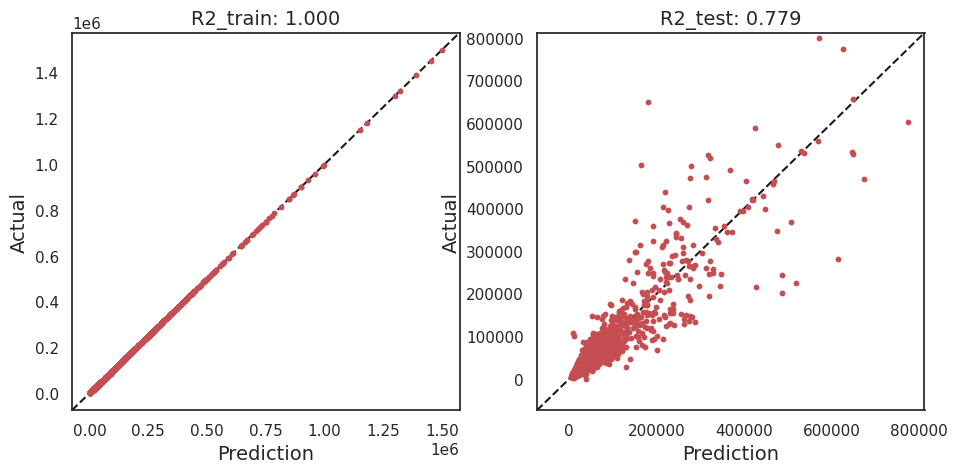

In [ ]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, gs_knr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



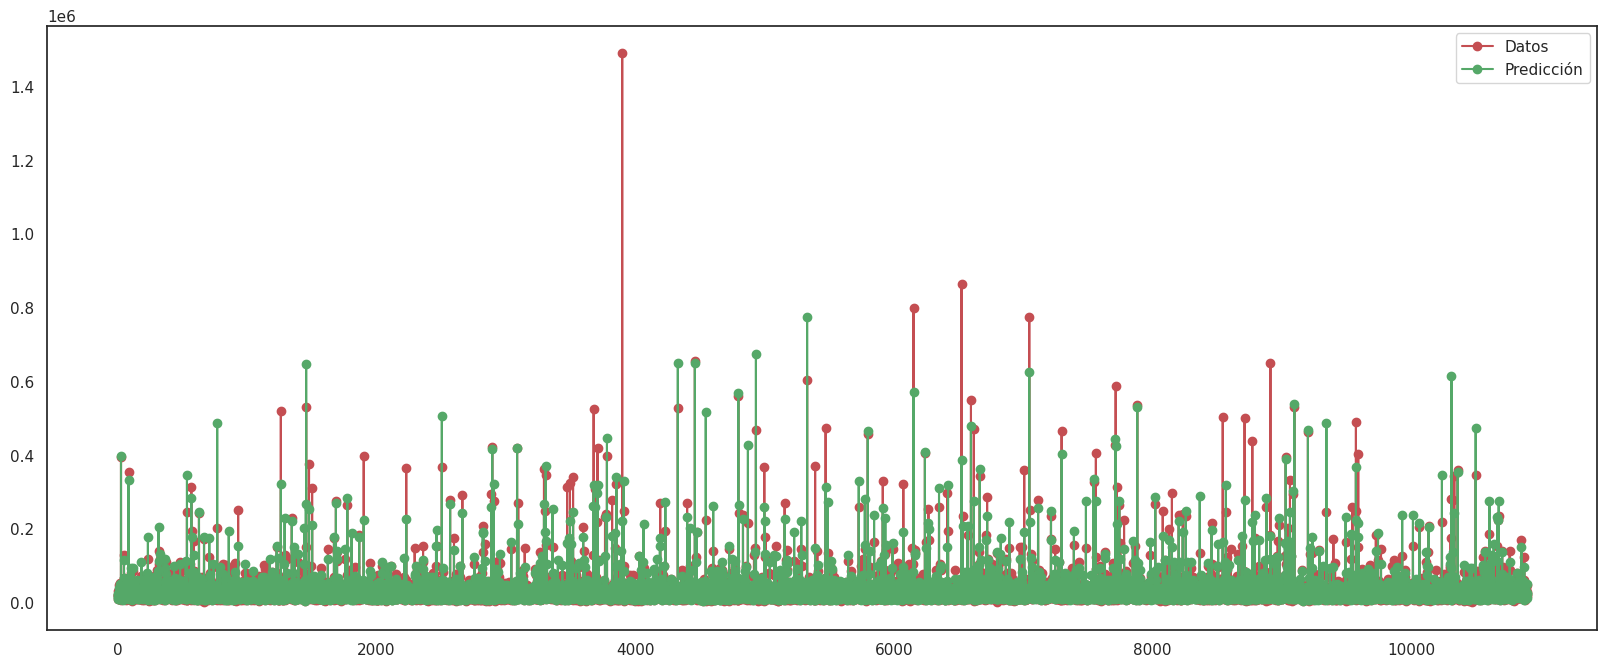

In [ ]:
sns.set(style="white")
plt.figure(figsize=(20,8))
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='Datos', marker='o')
plt.plot(xx, best_pipeline.predict(X_test), c='g', label='Predicción', marker='o')
plt.axis('tight')
plt.legend()
plt.show()